In [1]:
#6 8 12 16* 30* 32* 51**** 65***** 89* 96* n50_23

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import math
from scipy.integrate import quad, fixed_quad
import matplotlib.pyplot as plt
import pickle
import numpy as np
import functools
import sys
from tqdm import tqdm, trange
from aemulusnu_massfunction.utils import *
from aemulusnu_massfunction.emulator import *

from classy import Class

import math
import torch
import gpytorch
from matplotlib import pyplot as plt

import pyccl as ccl


In [4]:
# leave_out_box = 'Box89_1400'
leave_out_box = 'Box51_1400'

# leave_out_box = 'Box_n50_0_1400'
print('Leaving out', leave_out_box)

cosmos_f = open('../data/cosmo_params.pkl', 'rb')
cosmo_params = pickle.load(cosmos_f) #cosmo_params is a dict
cosmos_f.close()

a_list_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/alist.pkl'
a_list_f = open(a_list_fname, 'rb')
a_list = pickle.load(a_list_f)
a_list_f.close()

Leaving out Box51_1400


In [5]:
weird_boxes = []


errors = {a:{} for a in a_list}
X = []
Y = []
Xlo = []
Ylo = []
z_to_a = {}
a_to_z = {}
kt = np.logspace(-3, 1, 100) # h/Mpc
for box in tqdm(cosmo_params):
    if(box in weird_boxes):
        continue
    curr_cosmo = cosmo_params[box]
    if(box == 'Box_n50_0_1400'):
        print(curr_cosmo)

    curr_cosmo_values = [curr_cosmo[curr_key] for curr_key in key_ordering]

    h = curr_cosmo['H0']/100

    Ωb =  curr_cosmo['ombh2'] / h**2
    Ωc =  curr_cosmo['omch2'] / h**2

    cosmo = ccl.Cosmology(Omega_c=Ωc,
                          Omega_b=Ωb,
                          h=h,
                          A_s=curr_cosmo['10^9 As']*10**(-9),
                          n_s=curr_cosmo['ns'],
                          w0=curr_cosmo['w0'],
                          m_nu=[curr_cosmo['nu_mass_ev']/3, curr_cosmo['nu_mass_ev']/3, curr_cosmo['nu_mass_ev']/3])


    for a in a_list:
        z = scaleToRedshift(a)
#         if(z>2):
#             continue
        z_to_a[z] = a
        a_to_z[a] = z
        try:
            with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a), "rb") as f:
                MLE_params = pickle.load(f)
                param_values = list(MLE_params.values())
                if(leave_out_box == box):
                    Xlo += [curr_cosmo_values + [a]]
                    Ylo += [param_values]
                else:
                    Y+= [param_values]
                    X+= [curr_cosmo_values + [a]]
        except:
            print(box, z)

 43%|████▎     | 65/150 [00:00<00:00, 157.82it/s]

Box47_1400 2.3038301302700224


 79%|███████▉  | 119/150 [00:00<00:00, 171.92it/s]

{'ns': 0.97000003, 'H0': 67.0, 'w0': -1.0, 'ombh2': 0.0223, 'omch2': 0.12, 'nu_mass_ev': 0.07071068, '10^9 As': 2.10100315}


100%|██████████| 150/150 [00:00<00:00, 164.96it/s]


In [6]:
X = np.array(X)
Y = np.array(Y)
Xlo = np.array(Xlo)
Ylo = np.array(Ylo)
# print(Xlo)
# print(Ylo)

print(X.shape)
print(Y.shape)
################################
print('scaling input')
in_scaler = Normalizer()
in_scaler.fit(X)
X = in_scaler.transform(X)
Xlo = in_scaler.transform(Xlo)
print(X.shape)


print('scaling output')
out_scaler = Standardizer()
out_scaler.fit(Y)
Y = out_scaler.transform(Y)
print(Y.shape)

##REMEMBER TO UNSCALE OUTPUT AND SAVE SCALERS#####

X_train = torch.from_numpy(X).float()
Y_train = torch.from_numpy(Y).float()
n_tasks = len(Y_train[0])

(2234, 8)
(2234, 4)
scaling input
(2234, 8)
scaling output
(2234, 4)


In [7]:
from aemulusnu_massfunction.emulator import *


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=n_tasks,
                                                              has_global_noise=False, 
                                                              has_task_noise=True)
model = MultitaskGPModel(X_train, Y_train, likelihood)


# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.train()
likelihood.train()


training_iterations = 500

In [8]:
epochs_iter = tqdm(range(training_iterations), desc="Iteration")


# Create the optimizer with the initial learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, amsgrad=True)  # Includes GaussianLikelihood parameters

for i in epochs_iter:
    # Training step
    model.train()
    likelihood.train()

    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train)
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()
    print('Iter %d/%d - Loss: %.4f' % (i + 1, training_iterations, loss.item()))

    # Change learning rate after half of iterations
#     if i == training_iterations//10:
#         lr = 0.1
#         print('reducing lr to 0.1')
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lr

#     if i == 150:
#         lr = 0.01
#         print('reducing lr to 0.01')
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = lr
#-.926

Iteration:   0%|          | 1/500 [00:02<17:16,  2.08s/it, loss=2.35]

Iter 1/500 - Loss: 2.3488


Iteration:   0%|          | 2/500 [00:04<17:14,  2.08s/it, loss=2.07]

Iter 2/500 - Loss: 2.0704


Iteration:   1%|          | 3/500 [00:06<18:29,  2.23s/it, loss=1.81]

Iter 3/500 - Loss: 1.8132


Iteration:   1%|          | 4/500 [00:09<19:06,  2.31s/it, loss=1.58]

Iter 4/500 - Loss: 1.5778


Iteration:   1%|          | 5/500 [00:10<18:05,  2.19s/it, loss=1.37]

Iter 5/500 - Loss: 1.3652


Iteration:   1%|          | 6/500 [00:13<17:36,  2.14s/it, loss=1.18]

Iter 6/500 - Loss: 1.1761


Iteration:   1%|▏         | 7/500 [00:15<17:14,  2.10s/it, loss=1.01]

Iter 7/500 - Loss: 1.0108


Iteration:   2%|▏         | 8/500 [00:17<17:10,  2.09s/it, loss=0.871]

Iter 8/500 - Loss: 0.8710


Iteration:   2%|▏         | 9/500 [00:19<17:03,  2.08s/it, loss=0.759]

Iter 9/500 - Loss: 0.7592


Iteration:   2%|▏         | 10/500 [00:21<16:48,  2.06s/it, loss=0.676]

Iter 10/500 - Loss: 0.6756


Iteration:   2%|▏         | 11/500 [00:23<16:40,  2.05s/it, loss=0.617]

Iter 11/500 - Loss: 0.6167


Iteration:   2%|▏         | 12/500 [00:25<16:30,  2.03s/it, loss=0.577]

Iter 12/500 - Loss: 0.5766


Iteration:   3%|▎         | 13/500 [00:27<16:22,  2.02s/it, loss=0.548]

Iter 13/500 - Loss: 0.5484


Iteration:   3%|▎         | 14/500 [00:29<16:30,  2.04s/it, loss=0.525]

Iter 14/500 - Loss: 0.5245


Iteration:   3%|▎         | 15/500 [00:31<16:24,  2.03s/it, loss=0.5]  

Iter 15/500 - Loss: 0.4997


Iteration:   3%|▎         | 16/500 [00:33<16:17,  2.02s/it, loss=0.471]

Iter 16/500 - Loss: 0.4709


Iteration:   3%|▎         | 17/500 [00:35<16:11,  2.01s/it, loss=0.437]

Iter 17/500 - Loss: 0.4366


Iteration:   4%|▎         | 18/500 [00:37<16:13,  2.02s/it, loss=0.396]

Iter 18/500 - Loss: 0.3964


Iteration:   4%|▍         | 19/500 [00:39<16:08,  2.01s/it, loss=0.35] 

Iter 19/500 - Loss: 0.3499


Iteration:   4%|▍         | 20/500 [00:41<16:03,  2.01s/it, loss=0.298]

Iter 20/500 - Loss: 0.2978


Iteration:   4%|▍         | 21/500 [00:43<17:09,  2.15s/it, loss=0.242]

Iter 21/500 - Loss: 0.2417


Iteration:   4%|▍         | 22/500 [00:45<16:49,  2.11s/it, loss=0.185]

Iter 22/500 - Loss: 0.1850


Iteration:   5%|▍         | 23/500 [00:47<16:31,  2.08s/it, loss=0.131]

Iter 23/500 - Loss: 0.1311


Iteration:   5%|▍         | 24/500 [00:49<16:17,  2.05s/it, loss=0.0823]

Iter 24/500 - Loss: 0.0823


Iteration:   5%|▌         | 25/500 [00:51<16:12,  2.05s/it, loss=0.0391]

Iter 25/500 - Loss: 0.0391


Iteration:   5%|▌         | 26/500 [00:53<16:08,  2.04s/it, loss=0.000374]

Iter 26/500 - Loss: 0.0004


Iteration:   5%|▌         | 27/500 [00:55<16:01,  2.03s/it, loss=-.0356]  

Iter 27/500 - Loss: -0.0356


Iteration:   6%|▌         | 28/500 [00:57<16:02,  2.04s/it, loss=-.0705]

Iter 28/500 - Loss: -0.0705


Iteration:   6%|▌         | 29/500 [00:59<16:00,  2.04s/it, loss=-.106] 

Iter 29/500 - Loss: -0.1056


Iteration:   6%|▌         | 30/500 [01:01<15:52,  2.03s/it, loss=-.142]

Iter 30/500 - Loss: -0.1420


Iteration:   6%|▌         | 31/500 [01:03<15:47,  2.02s/it, loss=-.18] 

Iter 31/500 - Loss: -0.1802


Iteration:   6%|▋         | 32/500 [01:05<15:43,  2.02s/it, loss=-.22]

Iter 32/500 - Loss: -0.2202


Iteration:   7%|▋         | 33/500 [01:07<15:39,  2.01s/it, loss=-.262]

Iter 33/500 - Loss: -0.2617


Iteration:   7%|▋         | 34/500 [01:09<15:38,  2.01s/it, loss=-.304]

Iter 34/500 - Loss: -0.3039


Iteration:   7%|▋         | 35/500 [01:11<15:35,  2.01s/it, loss=-.346]

Iter 35/500 - Loss: -0.3458


Iteration:   7%|▋         | 36/500 [01:14<15:32,  2.01s/it, loss=-.386]

Iter 36/500 - Loss: -0.3864


Iteration:   7%|▋         | 37/500 [01:16<15:29,  2.01s/it, loss=-.425]

Iter 37/500 - Loss: -0.4246


Iteration:   8%|▊         | 38/500 [01:18<15:27,  2.01s/it, loss=-.459]

Iter 38/500 - Loss: -0.4594


Iteration:   8%|▊         | 39/500 [01:20<15:25,  2.01s/it, loss=-.49] 

Iter 39/500 - Loss: -0.4903


Iteration:   8%|▊         | 40/500 [01:22<15:22,  2.01s/it, loss=-.518]

Iter 40/500 - Loss: -0.5179


Iteration:   8%|▊         | 41/500 [01:24<15:22,  2.01s/it, loss=-.543]

Iter 41/500 - Loss: -0.5433


Iteration:   8%|▊         | 42/500 [01:26<15:21,  2.01s/it, loss=-.568]

Iter 42/500 - Loss: -0.5680


Iteration:   9%|▊         | 43/500 [01:28<15:18,  2.01s/it, loss=-.593]

Iter 43/500 - Loss: -0.5930


Iteration:   9%|▉         | 44/500 [01:30<15:16,  2.01s/it, loss=-.618]

Iter 44/500 - Loss: -0.6185


Iteration:   9%|▉         | 45/500 [01:32<15:18,  2.02s/it, loss=-.644]

Iter 45/500 - Loss: -0.6442


Iteration:   9%|▉         | 46/500 [01:34<15:15,  2.02s/it, loss=-.67] 

Iter 46/500 - Loss: -0.6699


Iteration:   9%|▉         | 47/500 [01:36<15:14,  2.02s/it, loss=-.695]

Iter 47/500 - Loss: -0.6950


Iteration:  10%|▉         | 48/500 [01:38<15:10,  2.01s/it, loss=-.719]

Iter 48/500 - Loss: -0.7192


Iteration:  10%|▉         | 49/500 [01:40<15:07,  2.01s/it, loss=-.742]

Iter 49/500 - Loss: -0.7424


Iteration:  10%|█         | 50/500 [01:42<15:35,  2.08s/it, loss=-.765]

Iter 50/500 - Loss: -0.7647


Iteration:  10%|█         | 51/500 [01:44<15:26,  2.06s/it, loss=-.786]

Iter 51/500 - Loss: -0.7861


Iteration:  10%|█         | 52/500 [01:46<15:17,  2.05s/it, loss=-.807]

Iter 52/500 - Loss: -0.8070


Iteration:  11%|█         | 53/500 [01:48<15:08,  2.03s/it, loss=-.827]

Iter 53/500 - Loss: -0.8273


Iteration:  11%|█         | 54/500 [01:50<15:01,  2.02s/it, loss=-.847]

Iter 54/500 - Loss: -0.8468


Iteration:  11%|█         | 55/500 [01:52<14:56,  2.01s/it, loss=-.865]

Iter 55/500 - Loss: -0.8653


Iteration:  11%|█         | 56/500 [01:54<14:52,  2.01s/it, loss=-.882]

Iter 56/500 - Loss: -0.8822


Iteration:  11%|█▏        | 57/500 [01:56<14:48,  2.01s/it, loss=-.897]

Iter 57/500 - Loss: -0.8972


Iteration:  12%|█▏        | 58/500 [01:58<14:45,  2.00s/it, loss=-.911]

Iter 58/500 - Loss: -0.9107


Iteration:  12%|█▏        | 59/500 [02:00<14:44,  2.01s/it, loss=-.923]

Iter 59/500 - Loss: -0.9233


Iteration:  12%|█▏        | 60/500 [02:02<14:43,  2.01s/it, loss=-.936]

Iter 60/500 - Loss: -0.9361


Iteration:  12%|█▏        | 61/500 [02:04<14:39,  2.00s/it, loss=-.949]

Iter 61/500 - Loss: -0.9493


Iteration:  12%|█▏        | 62/500 [02:06<14:36,  2.00s/it, loss=-.962]

Iter 62/500 - Loss: -0.9623


Iteration:  13%|█▎        | 63/500 [02:08<14:34,  2.00s/it, loss=-.975]

Iter 63/500 - Loss: -0.9746


Iteration:  13%|█▎        | 64/500 [02:10<14:31,  2.00s/it, loss=-.986]

Iter 64/500 - Loss: -0.9859


Iteration:  13%|█▎        | 65/500 [02:12<14:30,  2.00s/it, loss=-.996]

Iter 65/500 - Loss: -0.9965


Iteration:  13%|█▎        | 66/500 [02:14<14:28,  2.00s/it, loss=-1.01]

Iter 66/500 - Loss: -1.0066


Iteration:  13%|█▎        | 67/500 [02:16<14:26,  2.00s/it, loss=-1.02]

Iter 67/500 - Loss: -1.0164


Iteration:  14%|█▎        | 68/500 [02:18<14:35,  2.03s/it, loss=-1.03]

Iter 68/500 - Loss: -1.0256


Iteration:  14%|█▍        | 69/500 [02:20<14:30,  2.02s/it, loss=-1.03]

Iter 69/500 - Loss: -1.0342


Iteration:  14%|█▍        | 70/500 [02:22<14:25,  2.01s/it, loss=-1.04]

Iter 70/500 - Loss: -1.0419


Iteration:  14%|█▍        | 71/500 [02:24<14:22,  2.01s/it, loss=-1.05]

Iter 71/500 - Loss: -1.0489


Iteration:  14%|█▍        | 72/500 [02:26<14:19,  2.01s/it, loss=-1.06]

Iter 72/500 - Loss: -1.0555


Iteration:  15%|█▍        | 73/500 [02:28<14:16,  2.01s/it, loss=-1.06]

Iter 73/500 - Loss: -1.0621


Iteration:  15%|█▍        | 74/500 [02:30<14:12,  2.00s/it, loss=-1.07]

Iter 74/500 - Loss: -1.0686


Iteration:  15%|█▌        | 75/500 [02:32<14:12,  2.01s/it, loss=-1.07]

Iter 75/500 - Loss: -1.0747


Iteration:  15%|█▌        | 76/500 [02:34<14:08,  2.00s/it, loss=-1.08]

Iter 76/500 - Loss: -1.0801


Iteration:  15%|█▌        | 77/500 [02:36<14:07,  2.00s/it, loss=-1.08]

Iter 77/500 - Loss: -1.0846


Iteration:  16%|█▌        | 78/500 [02:38<14:05,  2.00s/it, loss=-1.09]

Iter 78/500 - Loss: -1.0880


Iteration:  16%|█▌        | 79/500 [02:40<14:02,  2.00s/it, loss=-1.09]

Iter 79/500 - Loss: -1.0903


Iteration:  16%|█▌        | 80/500 [02:43<15:02,  2.15s/it, loss=-1.09]

Iter 80/500 - Loss: -1.0937


Iteration:  16%|█▌        | 81/500 [02:45<14:42,  2.11s/it, loss=-1.1] 

Iter 81/500 - Loss: -1.0968


Iteration:  16%|█▋        | 82/500 [02:47<14:26,  2.07s/it, loss=-1.1]

Iter 82/500 - Loss: -1.0978


Iteration:  17%|█▋        | 83/500 [02:49<14:15,  2.05s/it, loss=-1.1]

Iter 83/500 - Loss: -1.0999


Iteration:  17%|█▋        | 84/500 [02:51<14:07,  2.04s/it, loss=-1.1]

Iter 84/500 - Loss: -1.1023


Iteration:  17%|█▋        | 85/500 [02:53<14:02,  2.03s/it, loss=-1.1]

Iter 85/500 - Loss: -1.1029


Iteration:  17%|█▋        | 86/500 [02:55<13:57,  2.02s/it, loss=-1.1]

Iter 86/500 - Loss: -1.1046


Iteration:  17%|█▋        | 87/500 [02:57<13:52,  2.02s/it, loss=-1.11]

Iter 87/500 - Loss: -1.1065


Iteration:  18%|█▊        | 88/500 [02:59<13:49,  2.01s/it, loss=-1.11]

Iter 88/500 - Loss: -1.1070


Iteration:  18%|█▊        | 89/500 [03:01<13:46,  2.01s/it, loss=-1.11]

Iter 89/500 - Loss: -1.1083


Iteration:  18%|█▊        | 90/500 [03:03<13:43,  2.01s/it, loss=-1.11]

Iter 90/500 - Loss: -1.1096


Iteration:  18%|█▊        | 91/500 [03:05<13:41,  2.01s/it, loss=-1.11]

Iter 91/500 - Loss: -1.1099


Iteration:  18%|█▊        | 92/500 [03:07<13:39,  2.01s/it, loss=-1.11]

Iter 92/500 - Loss: -1.1112


Iteration:  19%|█▊        | 93/500 [03:09<13:36,  2.01s/it, loss=-1.11]

Iter 93/500 - Loss: -1.1119


Iteration:  19%|█▉        | 94/500 [03:11<13:36,  2.01s/it, loss=-1.11]

Iter 94/500 - Loss: -1.1124


Iteration:  19%|█▉        | 95/500 [03:13<13:34,  2.01s/it, loss=-1.11]

Iter 95/500 - Loss: -1.1135


Iteration:  19%|█▉        | 96/500 [03:15<13:33,  2.01s/it, loss=-1.11]

Iter 96/500 - Loss: -1.1139


Iteration:  19%|█▉        | 97/500 [03:17<13:30,  2.01s/it, loss=-1.11]

Iter 97/500 - Loss: -1.1148


Iteration:  20%|█▉        | 98/500 [03:19<13:28,  2.01s/it, loss=-1.12]

Iter 98/500 - Loss: -1.1154


Iteration:  20%|█▉        | 99/500 [03:21<13:26,  2.01s/it, loss=-1.12]

Iter 99/500 - Loss: -1.1159


Iteration:  20%|██        | 100/500 [03:23<13:23,  2.01s/it, loss=-1.12]

Iter 100/500 - Loss: -1.1167


Iteration:  20%|██        | 101/500 [03:25<13:22,  2.01s/it, loss=-1.12]

Iter 101/500 - Loss: -1.1172


Iteration:  20%|██        | 102/500 [03:27<13:20,  2.01s/it, loss=-1.12]

Iter 102/500 - Loss: -1.1181


Iteration:  21%|██        | 103/500 [03:29<13:18,  2.01s/it, loss=-1.12]

Iter 103/500 - Loss: -1.1188


Iteration:  21%|██        | 104/500 [03:31<13:16,  2.01s/it, loss=-1.12]

Iter 104/500 - Loss: -1.1200


Iteration:  21%|██        | 105/500 [03:33<13:13,  2.01s/it, loss=-1.12]

Iter 105/500 - Loss: -1.1210


Iteration:  21%|██        | 106/500 [03:35<13:12,  2.01s/it, loss=-1.12]

Iter 106/500 - Loss: -1.1224


Iteration:  21%|██▏       | 107/500 [03:37<13:09,  2.01s/it, loss=-1.12]

Iter 107/500 - Loss: -1.1237


Iteration:  22%|██▏       | 108/500 [03:39<13:08,  2.01s/it, loss=-1.13]

Iter 108/500 - Loss: -1.1251


Iteration:  22%|██▏       | 109/500 [03:41<13:06,  2.01s/it, loss=-1.13]

Iter 109/500 - Loss: -1.1266


Iteration:  22%|██▏       | 110/500 [03:43<14:19,  2.20s/it, loss=-1.13]

Iter 110/500 - Loss: -1.1280


Iteration:  22%|██▏       | 111/500 [03:45<13:54,  2.14s/it, loss=-1.13]

Iter 111/500 - Loss: -1.1294


Iteration:  22%|██▏       | 112/500 [03:47<13:38,  2.11s/it, loss=-1.13]

Iter 112/500 - Loss: -1.1307


Iteration:  23%|██▎       | 113/500 [03:49<13:25,  2.08s/it, loss=-1.13]

Iter 113/500 - Loss: -1.1320


Iteration:  23%|██▎       | 114/500 [03:51<13:15,  2.06s/it, loss=-1.13]

Iter 114/500 - Loss: -1.1333


Iteration:  23%|██▎       | 115/500 [03:54<13:10,  2.05s/it, loss=-1.13]

Iter 115/500 - Loss: -1.1345


Iteration:  23%|██▎       | 116/500 [03:56<13:05,  2.05s/it, loss=-1.14]

Iter 116/500 - Loss: -1.1358


Iteration:  23%|██▎       | 117/500 [03:58<13:00,  2.04s/it, loss=-1.14]

Iter 117/500 - Loss: -1.1371


Iteration:  24%|██▎       | 118/500 [04:00<12:55,  2.03s/it, loss=-1.14]

Iter 118/500 - Loss: -1.1388


Iteration:  24%|██▍       | 119/500 [04:02<12:52,  2.03s/it, loss=-1.14]

Iter 119/500 - Loss: -1.1406


Iteration:  24%|██▍       | 120/500 [04:04<12:49,  2.03s/it, loss=-1.14]

Iter 120/500 - Loss: -1.1426


Iteration:  24%|██▍       | 121/500 [04:06<12:48,  2.03s/it, loss=-1.14]

Iter 121/500 - Loss: -1.1448


Iteration:  24%|██▍       | 122/500 [04:08<12:45,  2.02s/it, loss=-1.15]

Iter 122/500 - Loss: -1.1471


Iteration:  25%|██▍       | 123/500 [04:10<12:43,  2.02s/it, loss=-1.15]

Iter 123/500 - Loss: -1.1493


Iteration:  25%|██▍       | 124/500 [04:12<12:38,  2.02s/it, loss=-1.15]

Iter 124/500 - Loss: -1.1514


Iteration:  25%|██▌       | 125/500 [04:14<12:35,  2.01s/it, loss=-1.15]

Iter 125/500 - Loss: -1.1535


Iteration:  25%|██▌       | 126/500 [04:16<12:33,  2.01s/it, loss=-1.16]

Iter 126/500 - Loss: -1.1555


Iteration:  25%|██▌       | 127/500 [04:18<12:36,  2.03s/it, loss=-1.16]

Iter 127/500 - Loss: -1.1573


Iteration:  26%|██▌       | 128/500 [04:20<12:32,  2.02s/it, loss=-1.16]

Iter 128/500 - Loss: -1.1591


Iteration:  26%|██▌       | 129/500 [04:22<12:28,  2.02s/it, loss=-1.16]

Iter 129/500 - Loss: -1.1608


Iteration:  26%|██▌       | 130/500 [04:24<12:24,  2.01s/it, loss=-1.16]

Iter 130/500 - Loss: -1.1624


Iteration:  26%|██▌       | 131/500 [04:26<12:22,  2.01s/it, loss=-1.16]

Iter 131/500 - Loss: -1.1639


Iteration:  26%|██▋       | 132/500 [04:28<12:19,  2.01s/it, loss=-1.17]

Iter 132/500 - Loss: -1.1653


Iteration:  27%|██▋       | 133/500 [04:30<12:18,  2.01s/it, loss=-1.17]

Iter 133/500 - Loss: -1.1666


Iteration:  27%|██▋       | 134/500 [04:32<12:16,  2.01s/it, loss=-1.17]

Iter 134/500 - Loss: -1.1678


Iteration:  27%|██▋       | 135/500 [04:34<12:15,  2.01s/it, loss=-1.17]

Iter 135/500 - Loss: -1.1689


Iteration:  27%|██▋       | 136/500 [04:36<12:12,  2.01s/it, loss=-1.17]

Iter 136/500 - Loss: -1.1700


Iteration:  27%|██▋       | 137/500 [04:38<12:10,  2.01s/it, loss=-1.17]

Iter 137/500 - Loss: -1.1711


Iteration:  28%|██▊       | 138/500 [04:40<12:09,  2.02s/it, loss=-1.17]

Iter 138/500 - Loss: -1.1722


Iteration:  28%|██▊       | 139/500 [04:42<12:26,  2.07s/it, loss=-1.17]

Iter 139/500 - Loss: -1.1732


Iteration:  28%|██▊       | 140/500 [04:44<12:16,  2.05s/it, loss=-1.17]

Iter 140/500 - Loss: -1.1743


Iteration:  28%|██▊       | 141/500 [04:46<12:10,  2.03s/it, loss=-1.18]

Iter 141/500 - Loss: -1.1754


Iteration:  28%|██▊       | 142/500 [04:48<12:07,  2.03s/it, loss=-1.18]

Iter 142/500 - Loss: -1.1765


Iteration:  29%|██▊       | 143/500 [04:50<12:03,  2.03s/it, loss=-1.18]

Iter 143/500 - Loss: -1.1776


Iteration:  29%|██▉       | 144/500 [04:52<11:58,  2.02s/it, loss=-1.18]

Iter 144/500 - Loss: -1.1788


Iteration:  29%|██▉       | 145/500 [04:54<11:56,  2.02s/it, loss=-1.18]

Iter 145/500 - Loss: -1.1799


Iteration:  29%|██▉       | 146/500 [04:56<11:53,  2.01s/it, loss=-1.18]

Iter 146/500 - Loss: -1.1811


Iteration:  29%|██▉       | 147/500 [04:58<11:53,  2.02s/it, loss=-1.18]

Iter 147/500 - Loss: -1.1823


Iteration:  30%|██▉       | 148/500 [05:00<11:49,  2.02s/it, loss=-1.18]

Iter 148/500 - Loss: -1.1834


Iteration:  30%|██▉       | 149/500 [05:02<11:47,  2.02s/it, loss=-1.18]

Iter 149/500 - Loss: -1.1845


Iteration:  30%|███       | 150/500 [05:04<11:44,  2.01s/it, loss=-1.19]

Iter 150/500 - Loss: -1.1856


Iteration:  30%|███       | 151/500 [05:06<11:41,  2.01s/it, loss=-1.19]

Iter 151/500 - Loss: -1.1866


Iteration:  30%|███       | 152/500 [05:08<11:44,  2.02s/it, loss=-1.19]

Iter 152/500 - Loss: -1.1876


Iteration:  31%|███       | 153/500 [05:10<11:41,  2.02s/it, loss=-1.19]

Iter 153/500 - Loss: -1.1886


Iteration:  31%|███       | 154/500 [05:12<11:38,  2.02s/it, loss=-1.19]

Iter 154/500 - Loss: -1.1895


Iteration:  31%|███       | 155/500 [05:14<11:38,  2.02s/it, loss=-1.19]

Iter 155/500 - Loss: -1.1905


Iteration:  31%|███       | 156/500 [05:16<11:33,  2.02s/it, loss=-1.19]

Iter 156/500 - Loss: -1.1914


Iteration:  31%|███▏      | 157/500 [05:18<11:35,  2.03s/it, loss=-1.19]

Iter 157/500 - Loss: -1.1922


Iteration:  32%|███▏      | 158/500 [05:20<11:30,  2.02s/it, loss=-1.19]

Iter 158/500 - Loss: -1.1931


Iteration:  32%|███▏      | 159/500 [05:22<11:27,  2.02s/it, loss=-1.19]

Iter 159/500 - Loss: -1.1940


Iteration:  32%|███▏      | 160/500 [05:24<11:27,  2.02s/it, loss=-1.19]

Iter 160/500 - Loss: -1.1948


Iteration:  32%|███▏      | 161/500 [05:26<11:23,  2.02s/it, loss=-1.2] 

Iter 161/500 - Loss: -1.1957


Iteration:  32%|███▏      | 162/500 [05:28<11:21,  2.02s/it, loss=-1.2]

Iter 162/500 - Loss: -1.1965


Iteration:  33%|███▎      | 163/500 [05:30<11:18,  2.01s/it, loss=-1.2]

Iter 163/500 - Loss: -1.1974


Iteration:  33%|███▎      | 164/500 [05:33<11:17,  2.02s/it, loss=-1.2]

Iter 164/500 - Loss: -1.1982


Iteration:  33%|███▎      | 165/500 [05:35<11:14,  2.01s/it, loss=-1.2]

Iter 165/500 - Loss: -1.1990


Iteration:  33%|███▎      | 166/500 [05:37<11:12,  2.01s/it, loss=-1.2]

Iter 166/500 - Loss: -1.1999


Iteration:  33%|███▎      | 167/500 [05:39<11:09,  2.01s/it, loss=-1.2]

Iter 167/500 - Loss: -1.2007


Iteration:  34%|███▎      | 168/500 [05:41<11:10,  2.02s/it, loss=-1.2]

Iter 168/500 - Loss: -1.2016


Iteration:  34%|███▍      | 169/500 [05:43<12:21,  2.24s/it, loss=-1.2]

Iter 169/500 - Loss: -1.2024


Iteration:  34%|███▍      | 170/500 [05:45<11:56,  2.17s/it, loss=-1.2]

Iter 170/500 - Loss: -1.2032


Iteration:  34%|███▍      | 171/500 [05:47<11:39,  2.13s/it, loss=-1.2]

Iter 171/500 - Loss: -1.2040


Iteration:  34%|███▍      | 172/500 [05:49<11:24,  2.09s/it, loss=-1.2]

Iter 172/500 - Loss: -1.2048


Iteration:  35%|███▍      | 173/500 [05:51<11:13,  2.06s/it, loss=-1.21]

Iter 173/500 - Loss: -1.2056


Iteration:  35%|███▍      | 174/500 [05:53<11:06,  2.04s/it, loss=-1.21]

Iter 174/500 - Loss: -1.2064


Iteration:  35%|███▌      | 175/500 [05:55<10:59,  2.03s/it, loss=-1.21]

Iter 175/500 - Loss: -1.2073


Iteration:  35%|███▌      | 176/500 [05:57<10:57,  2.03s/it, loss=-1.21]

Iter 176/500 - Loss: -1.2080


Iteration:  35%|███▌      | 177/500 [05:59<10:53,  2.02s/it, loss=-1.21]

Iter 177/500 - Loss: -1.2088


Iteration:  36%|███▌      | 178/500 [06:01<10:49,  2.02s/it, loss=-1.21]

Iter 178/500 - Loss: -1.2096


Iteration:  36%|███▌      | 179/500 [06:03<10:51,  2.03s/it, loss=-1.21]

Iter 179/500 - Loss: -1.2104


Iteration:  36%|███▌      | 180/500 [06:05<10:46,  2.02s/it, loss=-1.21]

Iter 180/500 - Loss: -1.2112


Iteration:  36%|███▌      | 181/500 [06:07<10:42,  2.02s/it, loss=-1.21]

Iter 181/500 - Loss: -1.2119


Iteration:  36%|███▋      | 182/500 [06:09<10:39,  2.01s/it, loss=-1.21]

Iter 182/500 - Loss: -1.2127


Iteration:  37%|███▋      | 183/500 [06:11<10:38,  2.01s/it, loss=-1.21]

Iter 183/500 - Loss: -1.2135


Iteration:  37%|███▋      | 184/500 [06:13<10:36,  2.01s/it, loss=-1.21]

Iter 184/500 - Loss: -1.2142


Iteration:  37%|███▋      | 185/500 [06:15<10:32,  2.01s/it, loss=-1.21]

Iter 185/500 - Loss: -1.2150


Iteration:  37%|███▋      | 186/500 [06:18<10:44,  2.05s/it, loss=-1.22]

Iter 186/500 - Loss: -1.2157


Iteration:  37%|███▋      | 187/500 [06:20<10:56,  2.10s/it, loss=-1.22]

Iter 187/500 - Loss: -1.2165


Iteration:  38%|███▊      | 188/500 [06:22<10:45,  2.07s/it, loss=-1.22]

Iter 188/500 - Loss: -1.2172


Iteration:  38%|███▊      | 189/500 [06:24<10:36,  2.05s/it, loss=-1.22]

Iter 189/500 - Loss: -1.2180


Iteration:  38%|███▊      | 190/500 [06:26<10:31,  2.04s/it, loss=-1.22]

Iter 190/500 - Loss: -1.2187


Iteration:  38%|███▊      | 191/500 [06:28<10:25,  2.02s/it, loss=-1.22]

Iter 191/500 - Loss: -1.2195


Iteration:  38%|███▊      | 192/500 [06:30<10:20,  2.02s/it, loss=-1.22]

Iter 192/500 - Loss: -1.2202


Iteration:  39%|███▊      | 193/500 [06:32<10:20,  2.02s/it, loss=-1.22]

Iter 193/500 - Loss: -1.2210


Iteration:  39%|███▉      | 194/500 [06:34<10:15,  2.01s/it, loss=-1.22]

Iter 194/500 - Loss: -1.2218


Iteration:  39%|███▉      | 195/500 [06:36<10:15,  2.02s/it, loss=-1.22]

Iter 195/500 - Loss: -1.2225


Iteration:  39%|███▉      | 196/500 [06:38<11:01,  2.18s/it, loss=-1.22]

Iter 196/500 - Loss: -1.2233


Iteration:  39%|███▉      | 197/500 [06:40<10:44,  2.13s/it, loss=-1.22]

Iter 197/500 - Loss: -1.2240


Iteration:  40%|███▉      | 198/500 [06:43<11:04,  2.20s/it, loss=-1.22]

Iter 198/500 - Loss: -1.2247


Iteration:  40%|███▉      | 199/500 [06:45<10:47,  2.15s/it, loss=-1.23]

Iter 199/500 - Loss: -1.2254


Iteration:  40%|████      | 200/500 [06:47<10:33,  2.11s/it, loss=-1.23]

Iter 200/500 - Loss: -1.2261


Iteration:  40%|████      | 201/500 [06:49<10:22,  2.08s/it, loss=-1.23]

Iter 201/500 - Loss: -1.2268


Iteration:  40%|████      | 202/500 [06:51<10:13,  2.06s/it, loss=-1.23]

Iter 202/500 - Loss: -1.2274


Iteration:  41%|████      | 203/500 [06:53<10:07,  2.05s/it, loss=-1.23]

Iter 203/500 - Loss: -1.2281


Iteration:  41%|████      | 204/500 [06:55<10:02,  2.03s/it, loss=-1.23]

Iter 204/500 - Loss: -1.2287


Iteration:  41%|████      | 205/500 [06:57<09:59,  2.03s/it, loss=-1.23]

Iter 205/500 - Loss: -1.2294


Iteration:  41%|████      | 206/500 [06:59<09:54,  2.02s/it, loss=-1.23]

Iter 206/500 - Loss: -1.2300


Iteration:  41%|████▏     | 207/500 [07:01<09:51,  2.02s/it, loss=-1.23]

Iter 207/500 - Loss: -1.2306


Iteration:  42%|████▏     | 208/500 [07:03<09:49,  2.02s/it, loss=-1.23]

Iter 208/500 - Loss: -1.2312


Iteration:  42%|████▏     | 209/500 [07:05<09:48,  2.02s/it, loss=-1.23]

Iter 209/500 - Loss: -1.2318


Iteration:  42%|████▏     | 210/500 [07:07<09:45,  2.02s/it, loss=-1.23]

Iter 210/500 - Loss: -1.2324


Iteration:  42%|████▏     | 211/500 [07:09<09:42,  2.02s/it, loss=-1.23]

Iter 211/500 - Loss: -1.2329


Iteration:  42%|████▏     | 212/500 [07:11<09:41,  2.02s/it, loss=-1.23]

Iter 212/500 - Loss: -1.2335


Iteration:  43%|████▎     | 213/500 [07:13<09:39,  2.02s/it, loss=-1.23]

Iter 213/500 - Loss: -1.2340


Iteration:  43%|████▎     | 214/500 [07:15<09:36,  2.02s/it, loss=-1.23]

Iter 214/500 - Loss: -1.2346


Iteration:  43%|████▎     | 215/500 [07:17<09:33,  2.01s/it, loss=-1.24]

Iter 215/500 - Loss: -1.2351


Iteration:  43%|████▎     | 216/500 [07:19<09:34,  2.02s/it, loss=-1.24]

Iter 216/500 - Loss: -1.2357


Iteration:  43%|████▎     | 217/500 [07:21<09:32,  2.02s/it, loss=-1.24]

Iter 217/500 - Loss: -1.2362


Iteration:  44%|████▎     | 218/500 [07:23<09:34,  2.04s/it, loss=-1.24]

Iter 218/500 - Loss: -1.2367


Iteration:  44%|████▍     | 219/500 [07:25<09:33,  2.04s/it, loss=-1.24]

Iter 219/500 - Loss: -1.2372


Iteration:  44%|████▍     | 220/500 [07:27<09:30,  2.04s/it, loss=-1.24]

Iter 220/500 - Loss: -1.2377


Iteration:  44%|████▍     | 221/500 [07:29<09:34,  2.06s/it, loss=-1.24]

Iter 221/500 - Loss: -1.2382


Iteration:  44%|████▍     | 222/500 [07:31<09:29,  2.05s/it, loss=-1.24]

Iter 222/500 - Loss: -1.2387


Iteration:  45%|████▍     | 223/500 [07:33<09:24,  2.04s/it, loss=-1.24]

Iter 223/500 - Loss: -1.2392


Iteration:  45%|████▍     | 224/500 [07:35<09:22,  2.04s/it, loss=-1.24]

Iter 224/500 - Loss: -1.2396


Iteration:  45%|████▌     | 225/500 [07:38<09:39,  2.11s/it, loss=-1.24]

Iter 225/500 - Loss: -1.2401


Iteration:  45%|████▌     | 226/500 [07:40<09:30,  2.08s/it, loss=-1.24]

Iter 226/500 - Loss: -1.2406


Iteration:  45%|████▌     | 227/500 [07:42<09:31,  2.09s/it, loss=-1.24]

Iter 227/500 - Loss: -1.2411


Iteration:  46%|████▌     | 228/500 [07:44<09:22,  2.07s/it, loss=-1.24]

Iter 228/500 - Loss: -1.2416


Iteration:  46%|████▌     | 229/500 [07:46<09:15,  2.05s/it, loss=-1.24]

Iter 229/500 - Loss: -1.2421


Iteration:  46%|████▌     | 230/500 [07:48<09:12,  2.05s/it, loss=-1.24]

Iter 230/500 - Loss: -1.2425


Iteration:  46%|████▌     | 231/500 [07:50<09:12,  2.05s/it, loss=-1.24]

Iter 231/500 - Loss: -1.2430


Iteration:  46%|████▋     | 232/500 [07:52<09:06,  2.04s/it, loss=-1.24]

Iter 232/500 - Loss: -1.2435


Iteration:  47%|████▋     | 233/500 [07:54<09:03,  2.03s/it, loss=-1.24]

Iter 233/500 - Loss: -1.2440


Iteration:  47%|████▋     | 234/500 [07:56<09:02,  2.04s/it, loss=-1.24]

Iter 234/500 - Loss: -1.2445


Iteration:  47%|████▋     | 235/500 [07:58<08:58,  2.03s/it, loss=-1.24]

Iter 235/500 - Loss: -1.2450


Iteration:  47%|████▋     | 236/500 [08:00<08:54,  2.02s/it, loss=-1.25]

Iter 236/500 - Loss: -1.2454


Iteration:  47%|████▋     | 237/500 [08:02<08:54,  2.03s/it, loss=-1.25]

Iter 237/500 - Loss: -1.2459


Iteration:  48%|████▊     | 238/500 [08:04<08:50,  2.02s/it, loss=-1.25]

Iter 238/500 - Loss: -1.2463


Iteration:  48%|████▊     | 239/500 [08:06<08:46,  2.02s/it, loss=-1.25]

Iter 239/500 - Loss: -1.2466


Iteration:  48%|████▊     | 240/500 [08:08<08:44,  2.02s/it, loss=-1.25]

Iter 240/500 - Loss: -1.2470


Iteration:  48%|████▊     | 241/500 [08:10<08:45,  2.03s/it, loss=-1.25]

Iter 241/500 - Loss: -1.2473


Iteration:  48%|████▊     | 242/500 [08:12<08:42,  2.02s/it, loss=-1.25]

Iter 242/500 - Loss: -1.2477


Iteration:  49%|████▊     | 243/500 [08:14<08:39,  2.02s/it, loss=-1.25]

Iter 243/500 - Loss: -1.2480


Iteration:  49%|████▉     | 244/500 [08:16<08:39,  2.03s/it, loss=-1.25]

Iter 244/500 - Loss: -1.2484


Iteration:  49%|████▉     | 245/500 [08:19<08:51,  2.08s/it, loss=-1.25]

Iter 245/500 - Loss: -1.2488


Iteration:  49%|████▉     | 246/500 [08:21<08:46,  2.07s/it, loss=-1.25]

Iter 246/500 - Loss: -1.2492


Iteration:  49%|████▉     | 247/500 [08:23<08:40,  2.06s/it, loss=-1.25]

Iter 247/500 - Loss: -1.2496


Iteration:  50%|████▉     | 248/500 [08:25<08:36,  2.05s/it, loss=-1.25]

Iter 248/500 - Loss: -1.2499


Iteration:  50%|████▉     | 249/500 [08:27<08:34,  2.05s/it, loss=-1.25]

Iter 249/500 - Loss: -1.2503


Iteration:  50%|█████     | 250/500 [08:29<08:30,  2.04s/it, loss=-1.25]

Iter 250/500 - Loss: -1.2506


Iteration:  50%|█████     | 251/500 [08:31<08:27,  2.04s/it, loss=-1.25]

Iter 251/500 - Loss: -1.2510


Iteration:  50%|█████     | 252/500 [08:33<08:24,  2.03s/it, loss=-1.25]

Iter 252/500 - Loss: -1.2513


Iteration:  51%|█████     | 253/500 [08:35<08:21,  2.03s/it, loss=-1.25]

Iter 253/500 - Loss: -1.2517


Iteration:  51%|█████     | 254/500 [08:37<08:20,  2.04s/it, loss=-1.25]

Iter 254/500 - Loss: -1.2521


Iteration:  51%|█████     | 255/500 [08:39<08:17,  2.03s/it, loss=-1.25]

Iter 255/500 - Loss: -1.2524


Iteration:  51%|█████     | 256/500 [08:41<08:14,  2.03s/it, loss=-1.25]

Iter 256/500 - Loss: -1.2528


Iteration:  51%|█████▏    | 257/500 [08:43<08:38,  2.13s/it, loss=-1.25]

Iter 257/500 - Loss: -1.2532


Iteration:  52%|█████▏    | 258/500 [08:45<08:28,  2.10s/it, loss=-1.25]

Iter 258/500 - Loss: -1.2535


Iteration:  52%|█████▏    | 259/500 [08:47<08:20,  2.08s/it, loss=-1.25]

Iter 259/500 - Loss: -1.2539


Iteration:  52%|█████▏    | 260/500 [08:49<08:15,  2.06s/it, loss=-1.25]

Iter 260/500 - Loss: -1.2543


Iteration:  52%|█████▏    | 261/500 [08:51<08:09,  2.05s/it, loss=-1.25]

Iter 261/500 - Loss: -1.2547


Iteration:  52%|█████▏    | 262/500 [08:53<08:05,  2.04s/it, loss=-1.26]

Iter 262/500 - Loss: -1.2551


Iteration:  53%|█████▎    | 263/500 [08:55<08:02,  2.04s/it, loss=-1.26]

Iter 263/500 - Loss: -1.2555


Iteration:  53%|█████▎    | 264/500 [08:57<08:00,  2.04s/it, loss=-1.26]

Iter 264/500 - Loss: -1.2559


Iteration:  53%|█████▎    | 265/500 [08:59<07:57,  2.03s/it, loss=-1.26]

Iter 265/500 - Loss: -1.2564


Iteration:  53%|█████▎    | 266/500 [09:01<07:55,  2.03s/it, loss=-1.26]

Iter 266/500 - Loss: -1.2569


Iteration:  53%|█████▎    | 267/500 [09:04<07:52,  2.03s/it, loss=-1.26]

Iter 267/500 - Loss: -1.2574


Iteration:  54%|█████▎    | 268/500 [09:06<07:50,  2.03s/it, loss=-1.26]

Iter 268/500 - Loss: -1.2579


Iteration:  54%|█████▍    | 269/500 [09:08<07:47,  2.02s/it, loss=-1.26]

Iter 269/500 - Loss: -1.2585


Iteration:  54%|█████▍    | 270/500 [09:10<07:46,  2.03s/it, loss=-1.26]

Iter 270/500 - Loss: -1.2591


Iteration:  54%|█████▍    | 271/500 [09:12<07:44,  2.03s/it, loss=-1.26]

Iter 271/500 - Loss: -1.2598


Iteration:  54%|█████▍    | 272/500 [09:14<07:41,  2.02s/it, loss=-1.26]

Iter 272/500 - Loss: -1.2605


Iteration:  55%|█████▍    | 273/500 [09:16<07:39,  2.02s/it, loss=-1.26]

Iter 273/500 - Loss: -1.2613


Iteration:  55%|█████▍    | 274/500 [09:18<07:37,  2.03s/it, loss=-1.26]

Iter 274/500 - Loss: -1.2622


Iteration:  55%|█████▌    | 275/500 [09:20<07:45,  2.07s/it, loss=-1.26]

Iter 275/500 - Loss: -1.2632


Iteration:  55%|█████▌    | 276/500 [09:22<07:54,  2.12s/it, loss=-1.26]

Iter 276/500 - Loss: -1.2642


Iteration:  55%|█████▌    | 277/500 [09:24<07:45,  2.09s/it, loss=-1.27]

Iter 277/500 - Loss: -1.2653


Iteration:  56%|█████▌    | 278/500 [09:26<07:40,  2.07s/it, loss=-1.27]

Iter 278/500 - Loss: -1.2664


Iteration:  56%|█████▌    | 279/500 [09:28<07:34,  2.06s/it, loss=-1.27]

Iter 279/500 - Loss: -1.2675


Iteration:  56%|█████▌    | 280/500 [09:30<07:28,  2.04s/it, loss=-1.27]

Iter 280/500 - Loss: -1.2685


Iteration:  56%|█████▌    | 281/500 [09:32<07:26,  2.04s/it, loss=-1.27]

Iter 281/500 - Loss: -1.2695


Iteration:  56%|█████▋    | 282/500 [09:34<07:22,  2.03s/it, loss=-1.27]

Iter 282/500 - Loss: -1.2704


Iteration:  57%|█████▋    | 283/500 [09:36<07:20,  2.03s/it, loss=-1.27]

Iter 283/500 - Loss: -1.2713


Iteration:  57%|█████▋    | 284/500 [09:38<07:17,  2.03s/it, loss=-1.27]

Iter 284/500 - Loss: -1.2721


Iteration:  57%|█████▋    | 285/500 [09:40<07:14,  2.02s/it, loss=-1.27]

Iter 285/500 - Loss: -1.2728


Iteration:  57%|█████▋    | 286/500 [09:43<07:58,  2.24s/it, loss=-1.27]

Iter 286/500 - Loss: -1.2734


Iteration:  57%|█████▋    | 287/500 [09:45<07:43,  2.17s/it, loss=-1.27]

Iter 287/500 - Loss: -1.2741


Iteration:  58%|█████▊    | 288/500 [09:47<07:30,  2.12s/it, loss=-1.27]

Iter 288/500 - Loss: -1.2747


Iteration:  58%|█████▊    | 289/500 [09:49<07:22,  2.10s/it, loss=-1.28]

Iter 289/500 - Loss: -1.2753


Iteration:  58%|█████▊    | 290/500 [09:51<07:18,  2.09s/it, loss=-1.28]

Iter 290/500 - Loss: -1.2758


Iteration:  58%|█████▊    | 291/500 [09:53<07:11,  2.07s/it, loss=-1.28]

Iter 291/500 - Loss: -1.2764


Iteration:  58%|█████▊    | 292/500 [09:55<07:06,  2.05s/it, loss=-1.28]

Iter 292/500 - Loss: -1.2769


Iteration:  59%|█████▊    | 293/500 [09:57<07:05,  2.06s/it, loss=-1.28]

Iter 293/500 - Loss: -1.2774


Iteration:  59%|█████▉    | 294/500 [09:59<07:01,  2.04s/it, loss=-1.28]

Iter 294/500 - Loss: -1.2779


Iteration:  59%|█████▉    | 295/500 [10:01<06:57,  2.03s/it, loss=-1.28]

Iter 295/500 - Loss: -1.2784


Iteration:  59%|█████▉    | 296/500 [10:03<06:55,  2.03s/it, loss=-1.28]

Iter 296/500 - Loss: -1.2789


Iteration:  59%|█████▉    | 297/500 [10:05<06:51,  2.03s/it, loss=-1.28]

Iter 297/500 - Loss: -1.2794


Iteration:  60%|█████▉    | 298/500 [10:07<06:49,  2.03s/it, loss=-1.28]

Iter 298/500 - Loss: -1.2798


Iteration:  60%|█████▉    | 299/500 [10:09<06:46,  2.02s/it, loss=-1.28]

Iter 299/500 - Loss: -1.2803


Iteration:  60%|██████    | 300/500 [10:11<06:44,  2.02s/it, loss=-1.28]

Iter 300/500 - Loss: -1.2807


Iteration:  60%|██████    | 301/500 [10:13<06:41,  2.02s/it, loss=-1.28]

Iter 301/500 - Loss: -1.2812


Iteration:  60%|██████    | 302/500 [10:15<06:40,  2.02s/it, loss=-1.28]

Iter 302/500 - Loss: -1.2816


Iteration:  61%|██████    | 303/500 [10:18<06:44,  2.05s/it, loss=-1.28]

Iter 303/500 - Loss: -1.2821


Iteration:  61%|██████    | 304/500 [10:20<06:50,  2.09s/it, loss=-1.28]

Iter 304/500 - Loss: -1.2825


Iteration:  61%|██████    | 305/500 [10:22<06:43,  2.07s/it, loss=-1.28]

Iter 305/500 - Loss: -1.2829


Iteration:  61%|██████    | 306/500 [10:24<06:39,  2.06s/it, loss=-1.28]

Iter 306/500 - Loss: -1.2833


Iteration:  61%|██████▏   | 307/500 [10:26<06:35,  2.05s/it, loss=-1.28]

Iter 307/500 - Loss: -1.2837


Iteration:  62%|██████▏   | 308/500 [10:28<06:32,  2.04s/it, loss=-1.28]

Iter 308/500 - Loss: -1.2841


Iteration:  62%|██████▏   | 309/500 [10:30<06:30,  2.04s/it, loss=-1.28]

Iter 309/500 - Loss: -1.2845


Iteration:  62%|██████▏   | 310/500 [10:32<06:27,  2.04s/it, loss=-1.28]

Iter 310/500 - Loss: -1.2849


Iteration:  62%|██████▏   | 311/500 [10:34<06:24,  2.04s/it, loss=-1.29]

Iter 311/500 - Loss: -1.2852


Iteration:  62%|██████▏   | 312/500 [10:36<06:22,  2.03s/it, loss=-1.29]

Iter 312/500 - Loss: -1.2856


Iteration:  63%|██████▎   | 313/500 [10:38<06:19,  2.03s/it, loss=-1.29]

Iter 313/500 - Loss: -1.2859


Iteration:  63%|██████▎   | 314/500 [10:40<06:18,  2.04s/it, loss=-1.29]

Iter 314/500 - Loss: -1.2863


Iteration:  63%|██████▎   | 315/500 [10:42<06:38,  2.16s/it, loss=-1.29]

Iter 315/500 - Loss: -1.2866


Iteration:  63%|██████▎   | 316/500 [10:44<06:29,  2.12s/it, loss=-1.29]

Iter 316/500 - Loss: -1.2870


Iteration:  63%|██████▎   | 317/500 [10:47<06:22,  2.09s/it, loss=-1.29]

Iter 317/500 - Loss: -1.2873


Iteration:  64%|██████▎   | 318/500 [10:49<06:16,  2.07s/it, loss=-1.29]

Iter 318/500 - Loss: -1.2876


Iteration:  64%|██████▍   | 319/500 [10:51<06:12,  2.06s/it, loss=-1.29]

Iter 319/500 - Loss: -1.2879


Iteration:  64%|██████▍   | 320/500 [10:53<06:08,  2.05s/it, loss=-1.29]

Iter 320/500 - Loss: -1.2882


Iteration:  64%|██████▍   | 321/500 [10:55<06:04,  2.04s/it, loss=-1.29]

Iter 321/500 - Loss: -1.2886


Iteration:  64%|██████▍   | 322/500 [10:57<06:01,  2.03s/it, loss=-1.29]

Iter 322/500 - Loss: -1.2889


Iteration:  65%|██████▍   | 323/500 [10:59<06:00,  2.03s/it, loss=-1.29]

Iter 323/500 - Loss: -1.2891


Iteration:  65%|██████▍   | 324/500 [11:01<05:57,  2.03s/it, loss=-1.29]

Iter 324/500 - Loss: -1.2894


Iteration:  65%|██████▌   | 325/500 [11:03<05:55,  2.03s/it, loss=-1.29]

Iter 325/500 - Loss: -1.2897


Iteration:  65%|██████▌   | 326/500 [11:05<05:53,  2.03s/it, loss=-1.29]

Iter 326/500 - Loss: -1.2900


Iteration:  65%|██████▌   | 327/500 [11:07<05:50,  2.03s/it, loss=-1.29]

Iter 327/500 - Loss: -1.2902


Iteration:  66%|██████▌   | 328/500 [11:09<05:49,  2.03s/it, loss=-1.29]

Iter 328/500 - Loss: -1.2905


Iteration:  66%|██████▌   | 329/500 [11:11<05:46,  2.03s/it, loss=-1.29]

Iter 329/500 - Loss: -1.2908


Iteration:  66%|██████▌   | 330/500 [11:13<05:44,  2.03s/it, loss=-1.29]

Iter 330/500 - Loss: -1.2910


Iteration:  66%|██████▌   | 331/500 [11:15<05:42,  2.03s/it, loss=-1.29]

Iter 331/500 - Loss: -1.2913


Iteration:  66%|██████▋   | 332/500 [11:17<05:41,  2.03s/it, loss=-1.29]

Iter 332/500 - Loss: -1.2915


Iteration:  67%|██████▋   | 333/500 [11:19<05:40,  2.04s/it, loss=-1.29]

Iter 333/500 - Loss: -1.2917


Iteration:  67%|██████▋   | 334/500 [11:21<05:38,  2.04s/it, loss=-1.29]

Iter 334/500 - Loss: -1.2920


Iteration:  67%|██████▋   | 335/500 [11:23<05:36,  2.04s/it, loss=-1.29]

Iter 335/500 - Loss: -1.2922


Iteration:  67%|██████▋   | 336/500 [11:25<05:37,  2.06s/it, loss=-1.29]

Iter 336/500 - Loss: -1.2924


Iteration:  67%|██████▋   | 337/500 [11:27<05:34,  2.05s/it, loss=-1.29]

Iter 337/500 - Loss: -1.2926


Iteration:  68%|██████▊   | 338/500 [11:29<05:30,  2.04s/it, loss=-1.29]

Iter 338/500 - Loss: -1.2928


Iteration:  68%|██████▊   | 339/500 [11:31<05:27,  2.03s/it, loss=-1.29]

Iter 339/500 - Loss: -1.2931


Iteration:  68%|██████▊   | 340/500 [11:33<05:24,  2.03s/it, loss=-1.29]

Iter 340/500 - Loss: -1.2932


Iteration:  68%|██████▊   | 341/500 [11:35<05:22,  2.03s/it, loss=-1.29]

Iter 341/500 - Loss: -1.2935


Iteration:  68%|██████▊   | 342/500 [11:37<05:19,  2.03s/it, loss=-1.29]

Iter 342/500 - Loss: -1.2937


Iteration:  69%|██████▊   | 343/500 [11:39<05:18,  2.03s/it, loss=-1.29]

Iter 343/500 - Loss: -1.2938


Iteration:  69%|██████▉   | 344/500 [11:41<05:22,  2.07s/it, loss=-1.29]

Iter 344/500 - Loss: -1.2940


Iteration:  69%|██████▉   | 345/500 [11:44<05:19,  2.06s/it, loss=-1.29]

Iter 345/500 - Loss: -1.2942


Iteration:  69%|██████▉   | 346/500 [11:46<05:15,  2.05s/it, loss=-1.29]

Iter 346/500 - Loss: -1.2944


Iteration:  69%|██████▉   | 347/500 [11:48<05:12,  2.04s/it, loss=-1.29]

Iter 347/500 - Loss: -1.2946


Iteration:  70%|██████▉   | 348/500 [11:50<05:10,  2.04s/it, loss=-1.29]

Iter 348/500 - Loss: -1.2948


Iteration:  70%|██████▉   | 349/500 [11:52<05:07,  2.04s/it, loss=-1.29]

Iter 349/500 - Loss: -1.2949


Iteration:  70%|███████   | 350/500 [11:54<05:05,  2.04s/it, loss=-1.3] 

Iter 350/500 - Loss: -1.2951


Iteration:  70%|███████   | 351/500 [11:56<05:02,  2.03s/it, loss=-1.3]

Iter 351/500 - Loss: -1.2953


Iteration:  70%|███████   | 352/500 [11:58<05:00,  2.03s/it, loss=-1.3]

Iter 352/500 - Loss: -1.2954


Iteration:  71%|███████   | 353/500 [12:00<04:59,  2.04s/it, loss=-1.3]

Iter 353/500 - Loss: -1.2956


Iteration:  71%|███████   | 354/500 [12:02<04:56,  2.03s/it, loss=-1.3]

Iter 354/500 - Loss: -1.2958


Iteration:  71%|███████   | 355/500 [12:04<04:54,  2.03s/it, loss=-1.3]

Iter 355/500 - Loss: -1.2959


Iteration:  71%|███████   | 356/500 [12:06<04:52,  2.03s/it, loss=-1.3]

Iter 356/500 - Loss: -1.2961


Iteration:  71%|███████▏  | 357/500 [12:08<04:52,  2.04s/it, loss=-1.3]

Iter 357/500 - Loss: -1.2962


Iteration:  72%|███████▏  | 358/500 [12:10<04:52,  2.06s/it, loss=-1.3]

Iter 358/500 - Loss: -1.2964


Iteration:  72%|███████▏  | 359/500 [12:12<04:52,  2.07s/it, loss=-1.3]

Iter 359/500 - Loss: -1.2965


Iteration:  72%|███████▏  | 360/500 [12:14<04:48,  2.06s/it, loss=-1.3]

Iter 360/500 - Loss: -1.2967


Iteration:  72%|███████▏  | 361/500 [12:16<04:44,  2.05s/it, loss=-1.3]

Iter 361/500 - Loss: -1.2968


Iteration:  72%|███████▏  | 362/500 [12:18<04:46,  2.07s/it, loss=-1.3]

Iter 362/500 - Loss: -1.2970


Iteration:  73%|███████▎  | 363/500 [12:21<04:57,  2.17s/it, loss=-1.3]

Iter 363/500 - Loss: -1.2971


Iteration:  73%|███████▎  | 364/500 [12:23<04:49,  2.13s/it, loss=-1.3]

Iter 364/500 - Loss: -1.2973


Iteration:  73%|███████▎  | 365/500 [12:25<04:44,  2.11s/it, loss=-1.3]

Iter 365/500 - Loss: -1.2974


Iteration:  73%|███████▎  | 366/500 [12:27<04:39,  2.08s/it, loss=-1.3]

Iter 366/500 - Loss: -1.2975


Iteration:  73%|███████▎  | 367/500 [12:29<04:35,  2.07s/it, loss=-1.3]

Iter 367/500 - Loss: -1.2976


Iteration:  74%|███████▎  | 368/500 [12:31<04:33,  2.07s/it, loss=-1.3]

Iter 368/500 - Loss: -1.2978


Iteration:  74%|███████▍  | 369/500 [12:33<04:29,  2.06s/it, loss=-1.3]

Iter 369/500 - Loss: -1.2979


Iteration:  74%|███████▍  | 370/500 [12:35<04:26,  2.05s/it, loss=-1.3]

Iter 370/500 - Loss: -1.2980


Iteration:  74%|███████▍  | 371/500 [12:37<04:26,  2.06s/it, loss=-1.3]

Iter 371/500 - Loss: -1.2982


Iteration:  74%|███████▍  | 372/500 [12:39<04:23,  2.06s/it, loss=-1.3]

Iter 372/500 - Loss: -1.2983


Iteration:  75%|███████▍  | 373/500 [12:41<04:25,  2.09s/it, loss=-1.3]

Iter 373/500 - Loss: -1.2984


Iteration:  75%|███████▍  | 374/500 [12:43<04:25,  2.11s/it, loss=-1.3]

Iter 374/500 - Loss: -1.2985


Iteration:  75%|███████▌  | 375/500 [12:46<04:21,  2.09s/it, loss=-1.3]

Iter 375/500 - Loss: -1.2986


Iteration:  75%|███████▌  | 376/500 [12:48<04:17,  2.08s/it, loss=-1.3]

Iter 376/500 - Loss: -1.2988


Iteration:  75%|███████▌  | 377/500 [12:50<04:14,  2.07s/it, loss=-1.3]

Iter 377/500 - Loss: -1.2989


Iteration:  76%|███████▌  | 378/500 [12:52<04:11,  2.06s/it, loss=-1.3]

Iter 378/500 - Loss: -1.2990


Iteration:  76%|███████▌  | 379/500 [12:54<04:08,  2.05s/it, loss=-1.3]

Iter 379/500 - Loss: -1.2991


Iteration:  76%|███████▌  | 380/500 [12:56<04:05,  2.05s/it, loss=-1.3]

Iter 380/500 - Loss: -1.2992


Iteration:  76%|███████▌  | 381/500 [12:58<04:03,  2.04s/it, loss=-1.3]

Iter 381/500 - Loss: -1.2993


Iteration:  76%|███████▋  | 382/500 [13:00<04:01,  2.05s/it, loss=-1.3]

Iter 382/500 - Loss: -1.2994


Iteration:  77%|███████▋  | 383/500 [13:02<03:59,  2.05s/it, loss=-1.3]

Iter 383/500 - Loss: -1.2995


Iteration:  77%|███████▋  | 384/500 [13:04<03:57,  2.05s/it, loss=-1.3]

Iter 384/500 - Loss: -1.2996


Iteration:  77%|███████▋  | 385/500 [13:06<03:54,  2.04s/it, loss=-1.3]

Iter 385/500 - Loss: -1.2997


Iteration:  77%|███████▋  | 386/500 [13:08<03:52,  2.04s/it, loss=-1.3]

Iter 386/500 - Loss: -1.2998


Iteration:  77%|███████▋  | 387/500 [13:10<03:50,  2.04s/it, loss=-1.3]

Iter 387/500 - Loss: -1.2999


Iteration:  78%|███████▊  | 388/500 [13:12<03:48,  2.04s/it, loss=-1.3]

Iter 388/500 - Loss: -1.3000


Iteration:  78%|███████▊  | 389/500 [13:14<03:46,  2.04s/it, loss=-1.3]

Iter 389/500 - Loss: -1.3001


Iteration:  78%|███████▊  | 390/500 [13:24<08:09,  4.45s/it, loss=-1.3]

Iter 390/500 - Loss: -1.3002


Iteration:  78%|███████▊  | 391/500 [13:33<10:20,  5.69s/it, loss=-1.3]

Iter 391/500 - Loss: -1.3003


Iteration:  78%|███████▊  | 392/500 [13:35<08:20,  4.63s/it, loss=-1.3]

Iter 392/500 - Loss: -1.3004


Iteration:  79%|███████▊  | 393/500 [13:37<06:53,  3.87s/it, loss=-1.3]

Iter 393/500 - Loss: -1.3005


Iteration:  79%|███████▉  | 394/500 [13:39<05:54,  3.34s/it, loss=-1.3]

Iter 394/500 - Loss: -1.3006


Iteration:  79%|███████▉  | 395/500 [13:41<05:19,  3.04s/it, loss=-1.3]

Iter 395/500 - Loss: -1.3007


Iteration:  79%|███████▉  | 396/500 [13:44<04:52,  2.81s/it, loss=-1.3]

Iter 396/500 - Loss: -1.3008


Iteration:  79%|███████▉  | 397/500 [13:46<04:26,  2.59s/it, loss=-1.3]

Iter 397/500 - Loss: -1.3009


Iteration:  80%|███████▉  | 398/500 [13:48<04:09,  2.45s/it, loss=-1.3]

Iter 398/500 - Loss: -1.3009


Iteration:  80%|███████▉  | 399/500 [13:50<03:55,  2.34s/it, loss=-1.3]

Iter 399/500 - Loss: -1.3010


Iteration:  80%|████████  | 400/500 [13:52<03:47,  2.28s/it, loss=-1.3]

Iter 400/500 - Loss: -1.3011


Iteration:  80%|████████  | 401/500 [13:54<03:41,  2.24s/it, loss=-1.3]

Iter 401/500 - Loss: -1.3012


Iteration:  80%|████████  | 402/500 [13:56<03:34,  2.19s/it, loss=-1.3]

Iter 402/500 - Loss: -1.3013


Iteration:  81%|████████  | 403/500 [13:58<03:29,  2.16s/it, loss=-1.3]

Iter 403/500 - Loss: -1.3014


Iteration:  81%|████████  | 404/500 [14:01<03:25,  2.14s/it, loss=-1.3]

Iter 404/500 - Loss: -1.3014


Iteration:  81%|████████  | 405/500 [14:03<03:21,  2.12s/it, loss=-1.3]

Iter 405/500 - Loss: -1.3015


Iteration:  81%|████████  | 406/500 [14:05<03:18,  2.11s/it, loss=-1.3]

Iter 406/500 - Loss: -1.3016


Iteration:  81%|████████▏ | 407/500 [14:07<03:15,  2.10s/it, loss=-1.3]

Iter 407/500 - Loss: -1.3017


Iteration:  82%|████████▏ | 408/500 [14:09<03:13,  2.10s/it, loss=-1.3]

Iter 408/500 - Loss: -1.3017


Iteration:  82%|████████▏ | 409/500 [14:11<03:10,  2.09s/it, loss=-1.3]

Iter 409/500 - Loss: -1.3018


Iteration:  82%|████████▏ | 410/500 [14:13<03:08,  2.10s/it, loss=-1.3]

Iter 410/500 - Loss: -1.3019


Iteration:  82%|████████▏ | 411/500 [14:15<03:06,  2.09s/it, loss=-1.3]

Iter 411/500 - Loss: -1.3020


Iteration:  82%|████████▏ | 412/500 [14:17<03:03,  2.09s/it, loss=-1.3]

Iter 412/500 - Loss: -1.3020


Iteration:  83%|████████▎ | 413/500 [14:20<03:21,  2.31s/it, loss=-1.3]

Iter 413/500 - Loss: -1.3021


Iteration:  83%|████████▎ | 414/500 [14:22<03:13,  2.25s/it, loss=-1.3]

Iter 414/500 - Loss: -1.3022


Iteration:  83%|████████▎ | 415/500 [14:24<03:07,  2.20s/it, loss=-1.3]

Iter 415/500 - Loss: -1.3022


Iteration:  83%|████████▎ | 416/500 [14:26<03:02,  2.17s/it, loss=-1.3]

Iter 416/500 - Loss: -1.3023


Iteration:  83%|████████▎ | 417/500 [14:28<02:58,  2.15s/it, loss=-1.3]

Iter 417/500 - Loss: -1.3024


Iteration:  84%|████████▎ | 418/500 [14:31<02:55,  2.14s/it, loss=-1.3]

Iter 418/500 - Loss: -1.3024


Iteration:  84%|████████▍ | 419/500 [14:33<02:51,  2.12s/it, loss=-1.3]

Iter 419/500 - Loss: -1.3025


Iteration:  84%|████████▍ | 420/500 [14:35<02:49,  2.12s/it, loss=-1.3]

Iter 420/500 - Loss: -1.3026


Iteration:  84%|████████▍ | 421/500 [14:37<02:47,  2.11s/it, loss=-1.3]

Iter 421/500 - Loss: -1.3026


Iteration:  84%|████████▍ | 422/500 [14:39<02:44,  2.11s/it, loss=-1.3]

Iter 422/500 - Loss: -1.3027


Iteration:  85%|████████▍ | 423/500 [14:41<02:43,  2.12s/it, loss=-1.3]

Iter 423/500 - Loss: -1.3028


Iteration:  85%|████████▍ | 424/500 [14:43<02:46,  2.19s/it, loss=-1.3]

Iter 424/500 - Loss: -1.3028


Iteration:  85%|████████▌ | 425/500 [14:46<02:42,  2.17s/it, loss=-1.3]

Iter 425/500 - Loss: -1.3029


Iteration:  85%|████████▌ | 426/500 [14:48<02:38,  2.15s/it, loss=-1.3]

Iter 426/500 - Loss: -1.3029


Iteration:  85%|████████▌ | 427/500 [14:50<02:35,  2.13s/it, loss=-1.3]

Iter 427/500 - Loss: -1.3030


Iteration:  86%|████████▌ | 428/500 [14:52<02:33,  2.13s/it, loss=-1.3]

Iter 428/500 - Loss: -1.3030


Iteration:  86%|████████▌ | 429/500 [14:54<02:31,  2.14s/it, loss=-1.3]

Iter 429/500 - Loss: -1.3031


Iteration:  86%|████████▌ | 430/500 [14:56<02:28,  2.12s/it, loss=-1.3]

Iter 430/500 - Loss: -1.3032


Iteration:  86%|████████▌ | 431/500 [14:58<02:26,  2.12s/it, loss=-1.3]

Iter 431/500 - Loss: -1.3032


Iteration:  86%|████████▋ | 432/500 [15:00<02:23,  2.11s/it, loss=-1.3]

Iter 432/500 - Loss: -1.3033


Iteration:  87%|████████▋ | 433/500 [15:02<02:21,  2.11s/it, loss=-1.3]

Iter 433/500 - Loss: -1.3033


Iteration:  87%|████████▋ | 434/500 [15:05<02:19,  2.12s/it, loss=-1.3]

Iter 434/500 - Loss: -1.3034


Iteration:  87%|████████▋ | 435/500 [15:07<02:17,  2.11s/it, loss=-1.3]

Iter 435/500 - Loss: -1.3034


Iteration:  87%|████████▋ | 436/500 [15:09<02:15,  2.12s/it, loss=-1.3]

Iter 436/500 - Loss: -1.3035


Iteration:  87%|████████▋ | 437/500 [15:11<02:13,  2.11s/it, loss=-1.3]

Iter 437/500 - Loss: -1.3035


Iteration:  88%|████████▊ | 438/500 [15:13<02:10,  2.11s/it, loss=-1.3]

Iter 438/500 - Loss: -1.3036


Iteration:  88%|████████▊ | 439/500 [15:15<02:09,  2.12s/it, loss=-1.3]

Iter 439/500 - Loss: -1.3036


Iteration:  88%|████████▊ | 440/500 [15:17<02:07,  2.12s/it, loss=-1.3]

Iter 440/500 - Loss: -1.3037


Iteration:  88%|████████▊ | 441/500 [15:19<02:04,  2.12s/it, loss=-1.3]

Iter 441/500 - Loss: -1.3037


Iteration:  88%|████████▊ | 442/500 [15:22<02:02,  2.12s/it, loss=-1.3]

Iter 442/500 - Loss: -1.3037


Iteration:  89%|████████▊ | 443/500 [15:24<02:00,  2.12s/it, loss=-1.3]

Iter 443/500 - Loss: -1.3038


Iteration:  89%|████████▉ | 444/500 [15:26<01:58,  2.12s/it, loss=-1.3]

Iter 444/500 - Loss: -1.3038


Iteration:  89%|████████▉ | 445/500 [15:28<01:56,  2.12s/it, loss=-1.3]

Iter 445/500 - Loss: -1.3039


Iteration:  89%|████████▉ | 446/500 [15:30<01:54,  2.12s/it, loss=-1.3]

Iter 446/500 - Loss: -1.3039


Iteration:  89%|████████▉ | 447/500 [15:32<01:52,  2.12s/it, loss=-1.3]

Iter 447/500 - Loss: -1.3040


Iteration:  90%|████████▉ | 448/500 [15:34<01:50,  2.12s/it, loss=-1.3]

Iter 448/500 - Loss: -1.3040


Iteration:  90%|████████▉ | 449/500 [15:36<01:48,  2.12s/it, loss=-1.3]

Iter 449/500 - Loss: -1.3041


Iteration:  90%|█████████ | 450/500 [15:38<01:45,  2.12s/it, loss=-1.3]

Iter 450/500 - Loss: -1.3041


Iteration:  90%|█████████ | 451/500 [15:41<01:43,  2.12s/it, loss=-1.3]

Iter 451/500 - Loss: -1.3041


Iteration:  90%|█████████ | 452/500 [15:43<01:47,  2.25s/it, loss=-1.3]

Iter 452/500 - Loss: -1.3042


Iteration:  91%|█████████ | 453/500 [15:45<01:43,  2.21s/it, loss=-1.3]

Iter 453/500 - Loss: -1.3042


Iteration:  91%|█████████ | 454/500 [15:47<01:40,  2.18s/it, loss=-1.3]

Iter 454/500 - Loss: -1.3043


Iteration:  91%|█████████ | 455/500 [15:50<01:37,  2.16s/it, loss=-1.3]

Iter 455/500 - Loss: -1.3043


Iteration:  91%|█████████ | 456/500 [15:52<01:34,  2.15s/it, loss=-1.3]

Iter 456/500 - Loss: -1.3043


Iteration:  91%|█████████▏| 457/500 [15:54<01:32,  2.15s/it, loss=-1.3]

Iter 457/500 - Loss: -1.3044


Iteration:  92%|█████████▏| 458/500 [15:56<01:29,  2.14s/it, loss=-1.3]

Iter 458/500 - Loss: -1.3044


Iteration:  92%|█████████▏| 459/500 [15:58<01:27,  2.14s/it, loss=-1.3]

Iter 459/500 - Loss: -1.3045


Iteration:  92%|█████████▏| 460/500 [16:00<01:25,  2.14s/it, loss=-1.3]

Iter 460/500 - Loss: -1.3045


Iteration:  92%|█████████▏| 461/500 [16:02<01:23,  2.13s/it, loss=-1.3]

Iter 461/500 - Loss: -1.3045


Iteration:  92%|█████████▏| 462/500 [16:04<01:20,  2.13s/it, loss=-1.3]

Iter 462/500 - Loss: -1.3046


Iteration:  93%|█████████▎| 463/500 [16:07<01:18,  2.13s/it, loss=-1.3]

Iter 463/500 - Loss: -1.3046


Iteration:  93%|█████████▎| 464/500 [16:09<01:16,  2.13s/it, loss=-1.3]

Iter 464/500 - Loss: -1.3046


Iteration:  93%|█████████▎| 465/500 [16:11<01:14,  2.13s/it, loss=-1.3]

Iter 465/500 - Loss: -1.3047


Iteration:  93%|█████████▎| 466/500 [16:13<01:12,  2.13s/it, loss=-1.3]

Iter 466/500 - Loss: -1.3047


Iteration:  93%|█████████▎| 467/500 [16:15<01:10,  2.13s/it, loss=-1.3]

Iter 467/500 - Loss: -1.3047


Iteration:  94%|█████████▎| 468/500 [16:17<01:08,  2.13s/it, loss=-1.3]

Iter 468/500 - Loss: -1.3048


Iteration:  94%|█████████▍| 469/500 [16:20<01:12,  2.34s/it, loss=-1.3]

Iter 469/500 - Loss: -1.3048


Iteration:  94%|█████████▍| 470/500 [16:22<01:08,  2.28s/it, loss=-1.3]

Iter 470/500 - Loss: -1.3048


Iteration:  94%|█████████▍| 471/500 [16:24<01:04,  2.23s/it, loss=-1.3]

Iter 471/500 - Loss: -1.3049


Iteration:  94%|█████████▍| 472/500 [16:26<01:01,  2.20s/it, loss=-1.3]

Iter 472/500 - Loss: -1.3049


Iteration:  95%|█████████▍| 473/500 [16:29<00:58,  2.18s/it, loss=-1.3]

Iter 473/500 - Loss: -1.3049


Iteration:  95%|█████████▍| 474/500 [16:31<00:56,  2.16s/it, loss=-1.3]

Iter 474/500 - Loss: -1.3050


Iteration:  95%|█████████▌| 475/500 [16:33<00:53,  2.15s/it, loss=-1.3]

Iter 475/500 - Loss: -1.3050


Iteration:  95%|█████████▌| 476/500 [16:35<00:51,  2.15s/it, loss=-1.31]

Iter 476/500 - Loss: -1.3050


Iteration:  95%|█████████▌| 477/500 [16:37<00:49,  2.14s/it, loss=-1.31]

Iter 477/500 - Loss: -1.3051


Iteration:  96%|█████████▌| 478/500 [16:39<00:46,  2.13s/it, loss=-1.31]

Iter 478/500 - Loss: -1.3051


Iteration:  96%|█████████▌| 479/500 [16:41<00:45,  2.17s/it, loss=-1.31]

Iter 479/500 - Loss: -1.3051


Iteration:  96%|█████████▌| 480/500 [16:44<00:44,  2.20s/it, loss=-1.31]

Iter 480/500 - Loss: -1.3051


Iteration:  96%|█████████▌| 481/500 [16:46<00:41,  2.18s/it, loss=-1.31]

Iter 481/500 - Loss: -1.3052


Iteration:  96%|█████████▋| 482/500 [16:48<00:39,  2.17s/it, loss=-1.31]

Iter 482/500 - Loss: -1.3052


Iteration:  97%|█████████▋| 483/500 [16:50<00:36,  2.16s/it, loss=-1.31]

Iter 483/500 - Loss: -1.3052


Iteration:  97%|█████████▋| 484/500 [16:52<00:34,  2.15s/it, loss=-1.31]

Iter 484/500 - Loss: -1.3053


Iteration:  97%|█████████▋| 485/500 [16:54<00:32,  2.15s/it, loss=-1.31]

Iter 485/500 - Loss: -1.3053


Iteration:  97%|█████████▋| 486/500 [16:56<00:30,  2.14s/it, loss=-1.31]

Iter 486/500 - Loss: -1.3053


Iteration:  97%|█████████▋| 487/500 [16:59<00:27,  2.14s/it, loss=-1.31]

Iter 487/500 - Loss: -1.3053


Iteration:  98%|█████████▊| 488/500 [17:02<00:29,  2.48s/it, loss=-1.31]

Iter 488/500 - Loss: -1.3054


Iteration:  98%|█████████▊| 489/500 [17:04<00:26,  2.38s/it, loss=-1.31]

Iter 489/500 - Loss: -1.3054


Iteration:  98%|█████████▊| 490/500 [17:06<00:23,  2.31s/it, loss=-1.31]

Iter 490/500 - Loss: -1.3054


Iteration:  98%|█████████▊| 491/500 [17:08<00:20,  2.26s/it, loss=-1.31]

Iter 491/500 - Loss: -1.3054


Iteration:  98%|█████████▊| 492/500 [17:10<00:17,  2.23s/it, loss=-1.31]

Iter 492/500 - Loss: -1.3055


Iteration:  99%|█████████▊| 493/500 [17:13<00:15,  2.20s/it, loss=-1.31]

Iter 493/500 - Loss: -1.3055


Iteration:  99%|█████████▉| 494/500 [17:15<00:13,  2.18s/it, loss=-1.31]

Iter 494/500 - Loss: -1.3055


Iteration:  99%|█████████▉| 495/500 [17:17<00:10,  2.16s/it, loss=-1.31]

Iter 495/500 - Loss: -1.3056


Iteration:  99%|█████████▉| 496/500 [17:19<00:08,  2.15s/it, loss=-1.31]

Iter 496/500 - Loss: -1.3056


Iteration:  99%|█████████▉| 497/500 [17:21<00:06,  2.16s/it, loss=-1.31]

Iter 497/500 - Loss: -1.3056


Iteration: 100%|█████████▉| 498/500 [17:23<00:04,  2.15s/it, loss=-1.31]

Iter 498/500 - Loss: -1.3056


Iteration: 100%|█████████▉| 499/500 [17:25<00:02,  2.14s/it, loss=-1.31]

Iter 499/500 - Loss: -1.3057


Iteration: 100%|██████████| 500/500 [17:28<00:00,  2.10s/it, loss=-1.31]

Iter 500/500 - Loss: -1.3057


In [9]:
model.state_dict()

OrderedDict([('likelihood.raw_task_noises',
              tensor([-6.2186, -8.4381, -7.6917, -9.5315])),
             ('likelihood.raw_task_noises_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.raw_task_noises_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.base_means.0.weights',
              tensor([[-1.3260],
                      [-0.3698],
                      [-0.6427],
                      [ 0.1780],
                      [ 0.0660],
                      [-0.8428],
                      [ 1.7244],
                      [-1.6078]])),
             ('mean_module.base_means.0.bias', tensor([1.6848])),
             ('mean_module.base_means.1.weights',
              tensor([[ 0.2929],
                      [ 0.2146],
                      [-0.1744],
                      [-0.4194],
                      [-0.1160],
                      [ 1.0173],
                      [-0.4632],
                      [ 1.3616]]))

In [10]:
from aemulusnu_massfunction.massfunction import *

with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/GP_lo%s.pkl"%(leave_out_box), "wb") as f:
    pickle.dump([model,
                in_scaler,
                out_scaler,
                likelihood,], f)



In [11]:
Emulator = AemulusNu_HMF_Emulator(emulator_loc = "/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/GP_lo%s.pkl"%(leave_out_box))

In [12]:
box =leave_out_box
from aemulusnu_massfunction.massfunction import *

NvM_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_NvsM.pkl'
NvM_f = open(NvM_fname, 'rb')
NvMs = pickle.load(NvM_f) #NvMs is a dictionary of dictionaries
NvM_f.close()

N_data = {}
M_data = {}
aux_data = {}

vol = -1 #Mpc^3/h^3
Mpart = -1

for a in tqdm(a_list):
#     if(a != 1): #TEST
#         continue
    c_data = NvMs[a]

    Ms = c_data['M'] #units of h^-1 Msolar
    N = c_data['N']
    edge_pairs = c_data['edge_pairs']
    assert(len(Ms) == len(edge_pairs))
    assert(len(Ms) == len(N))

    if(vol==-1):
        vol = c_data['vol']
    assert(vol == c_data['vol'])

    if(Mpart==-1):
        Mpart = c_data['Mpart']
    assert(Mpart == c_data['Mpart'])

    N_data[a] = []
    M_data[a] = []
    aux_data[a] = []
    for N_curr, M_curr, edge_pair in zip(N, Ms, edge_pairs):
        N_data[a] += [N_curr]
        M_data[a] += [M_curr]
        aux_data[a] += [{'a':a, 'edge_pair':edge_pair}]

100%|██████████| 15/15 [00:00<00:00, 29565.11it/s]


In [13]:
M_numerics = np.logspace(np.log10(100*Mpart), 16, 50)

jackknife_covs_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+box+'_jackknife_covs.pkl'
jackknife_covs_f = open(jackknife_covs_fname, 'rb')
jackknife = pickle.load(jackknife_covs_f)
jackknife_covs_f.close()

jack_covs = {a:jackknife[a][1] for a in N_data}

# Compute the weighted covariance matrix incorporating jackknife and poisson
weighted_cov = {a: jack_covs[a] for a in jack_covs}

param_names = ['d','e','f','g']


true_params = {}
for c_X, c_Y, a in zip(Xlo, Ylo, a_list):
    true_params[a] = c_Y

ccl_cosmo = get_ccl_cosmology(tuple(get_cosmo_vals(cosmo_params[leave_out_box])))

h = cosmo_params[leave_out_box]['H0']/100


100%|██████████| 2/2 [00:34<00:00, 17.42s/it]


(1.2, 1.3)

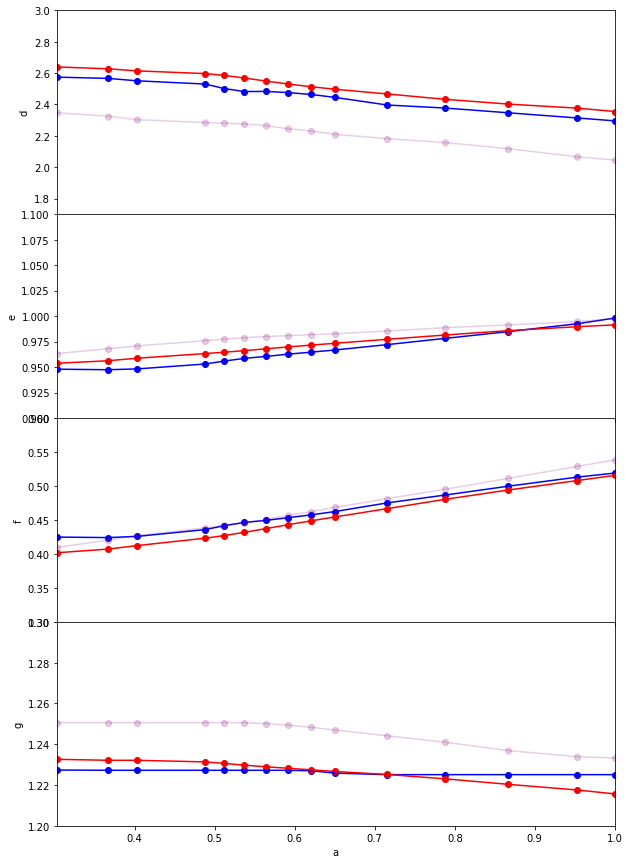

In [14]:

import matplotlib.pyplot as plt
box = 'Box_n50_14_1400'
# box = 'Box_n50_0_1400' 
# box = 'Box_n50_42_1400' #eh
box = leave_out_box
# box = 'Box_n50_33_1400'
# box = 'Box_n50_11_1400'
box = 'Box0_1400'
# box = 'Box51_1400'
# box = 'Box92_1400'
# box = 'Box86_1400'


fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(10,15), sharex=True)
wjat = [leave_out_box, 'Box_n50_0_1400', 'Box_n50_14_1400', 'Box_n50_33_1400', 'Box_n50_32_1400']
wjat = [leave_out_box, 'Box98_1400']

# for box in [leave_out_box]:#, 'Box_n50_14_1400']:
# for box in [leave_out_box, 'Box98_1400', 'Box_n50_0_1400']:#, 'Box_n50_14_1400', 'Box_n50_33_1400', 'Box_n50_32_1400']:
for box in tqdm(wjat):
    curr_cosmo_vals = tuple(get_cosmo_vals(cosmo_params[box]))
    curr_ccl_cosmo = get_ccl_cosmology(curr_cosmo_vals)

    param_names = ['d','e','f','g']
    ndim = len(param_names)
    plt.subplots_adjust(wspace=0, hspace=0)

    params = {'d':[], 'e':[], 'f':[], 'g':[]}
    paramsEMU = {'d':[], 'e':[], 'f':[], 'g':[]}

    for a in a_list:
        R = 8 / (cosmo_params[box]['H0'] / 100)
        sigma8z = cosmo.sigmaR(R, a=a)
        EMU  = (Emulator.predict_params(cosmo_params[box], scaleToRedshift(a))) #, sigma8z))

        with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a), "rb") as f:
            MLE_params = pickle.load(f)
        for key in MLE_params:
            params[key] += [MLE_params[key]]
            paramsEMU[key] += [EMU[key]]


    for i, param in enumerate(params):
        aaaaa = 1
        if(box != leave_out_box):
            aaaaa = 0.1
        axs[i].scatter(a_list, params[param], alpha=aaaaa, color='blue')
#         print(list(zip(a_list,params[param])))
#         print()
        axs[i].plot(a_list, params[param], alpha=aaaaa, color='blue')

        axs[i].scatter(a_list, paramsEMU[param], alpha=aaaaa, color='red')
        axs[i].plot(a_list, paramsEMU[param], alpha=aaaaa, color='red')

        axs[i].set_ylabel(param)
    #     axs[i].set_ylim([0,2])
        axs[i].set_xlim([min(a_list), 1])

axs[-1].set_xlabel('a')
# axs[0].set_ylim([0.25,.45])
# axs[1].set_ylim([0.29,.305])
# axs[2].set_ylim([1.4,1.8])
# axs[3].set_ylim([1.18, 1.2])
axs[0].set_ylim([1.7, 3.])
axs[1].set_ylim([0.9, 1.1])
axs[2].set_ylim([.3,.6])
axs[3].set_ylim([1.2,1.3])
# axs[0].set_title(box)

In [15]:
MLE_params.keys()

dict_keys(['d', 'e', 'f', 'g'])

In [16]:
box = leave_out_box


  0%|          | 0/15 [00:00<?, ?it/s]

[2.2955389495544836, 0.9981425478076322, 0.5190991297851273, 1.225094145736517]


  7%|▋         | 1/15 [00:04<01:00,  4.34s/it]

[2.313865703018104, 0.9926144108971242, 0.513193512410149, 1.225094490026511]


 13%|█▎        | 2/15 [00:05<00:31,  2.41s/it]

[2.347198622962069, 0.9848067806915171, 0.499709023346938, 1.2250955660837295]


 20%|██        | 3/15 [00:06<00:22,  1.84s/it]

[2.377474700078481, 0.9781656022937859, 0.48667287691605865, 1.2250961530530615]


 27%|██▋       | 4/15 [00:07<00:16,  1.54s/it]

[2.3966083490021424, 0.9721033398002745, 0.4752309211767195, 1.2250965507942946]


 33%|███▎      | 5/15 [00:08<00:13,  1.33s/it]

[2.445166876948077, 0.9668266117850863, 0.4625245605709027, 1.2258405593015147]


 40%|████      | 6/15 [00:09<00:11,  1.26s/it]

[2.464067392797804, 0.9646819512707978, 0.4575198569086816, 1.2270016444723733]


 47%|████▋     | 7/15 [00:10<00:09,  1.15s/it]

[2.476069263488937, 0.9626768753618182, 0.4533518882452041, 1.227231639720248]


 53%|█████▎    | 8/15 [00:11<00:07,  1.09s/it]

[2.4833291293975415, 0.9604682096728396, 0.4493797874908274, 1.227232421693951]


 60%|██████    | 9/15 [00:12<00:06,  1.09s/it]

[2.4824242629756195, 0.9586241291962907, 0.44648813605489324, 1.2272338981809843]


 67%|██████▋   | 10/15 [00:13<00:05,  1.03s/it]

[2.5013159026037775, 0.9559716434464816, 0.4417367604369007, 1.227233956926851]


 73%|███████▎  | 11/15 [00:14<00:03,  1.01it/s]

[2.5302753533349245, 0.9530832278826333, 0.4359337676225823, 1.2272340262926125]


 80%|████████  | 12/15 [00:15<00:02,  1.04it/s]

[2.5509321061880357, 0.9482760962015031, 0.4259358202922211, 1.2272344313219152]


 87%|████████▋ | 13/15 [00:16<00:01,  1.07it/s]

[2.566379527330179, 0.9474586022195612, 0.4241460461934392, 1.2272344809281188]


 93%|█████████▎| 14/15 [00:17<00:00,  1.03it/s]

[2.5744916500145094, 0.9479926118111496, 0.42492610505116063, 1.2273516706867516]


100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


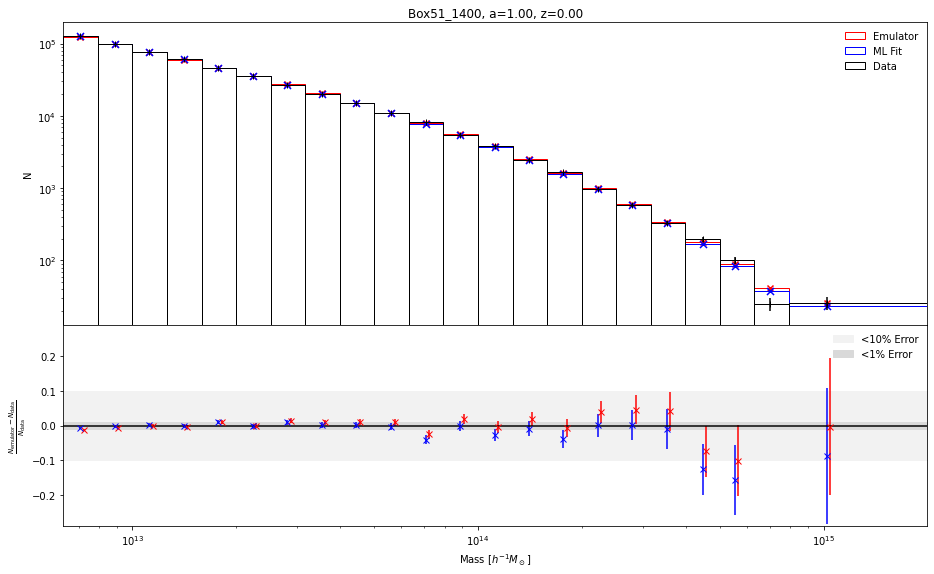

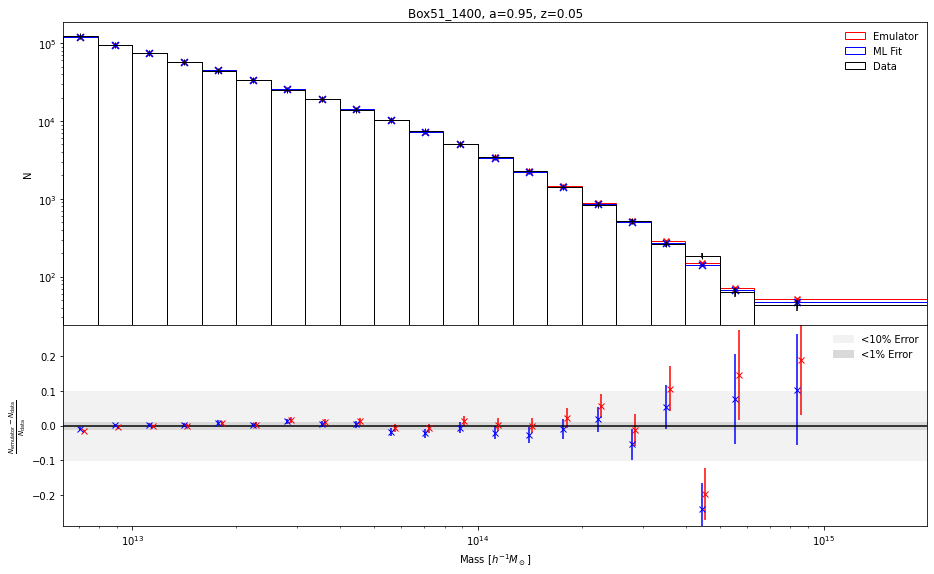

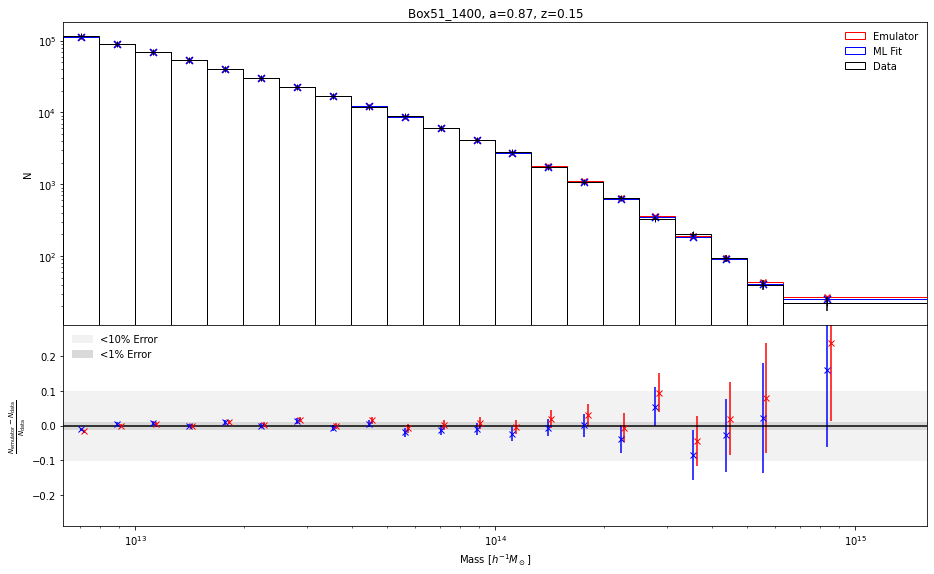

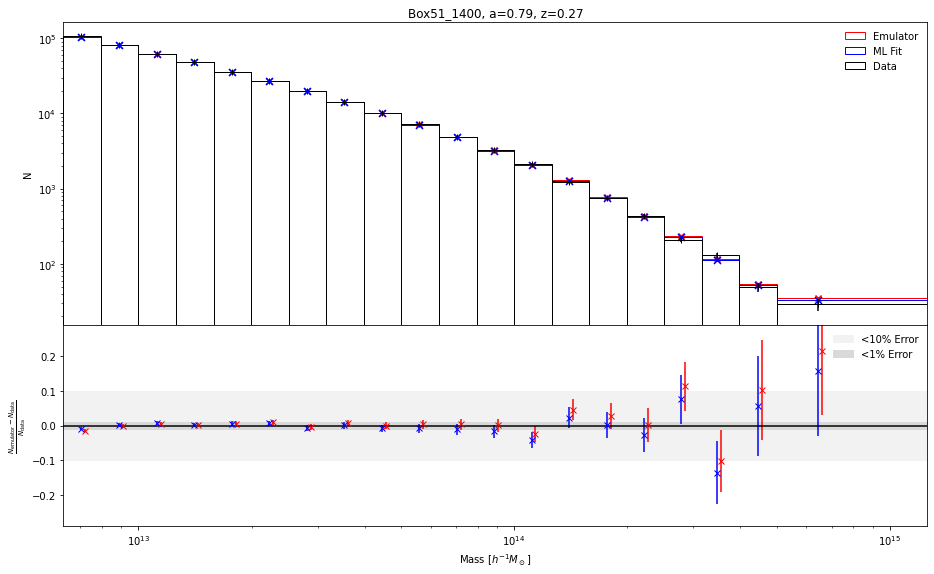

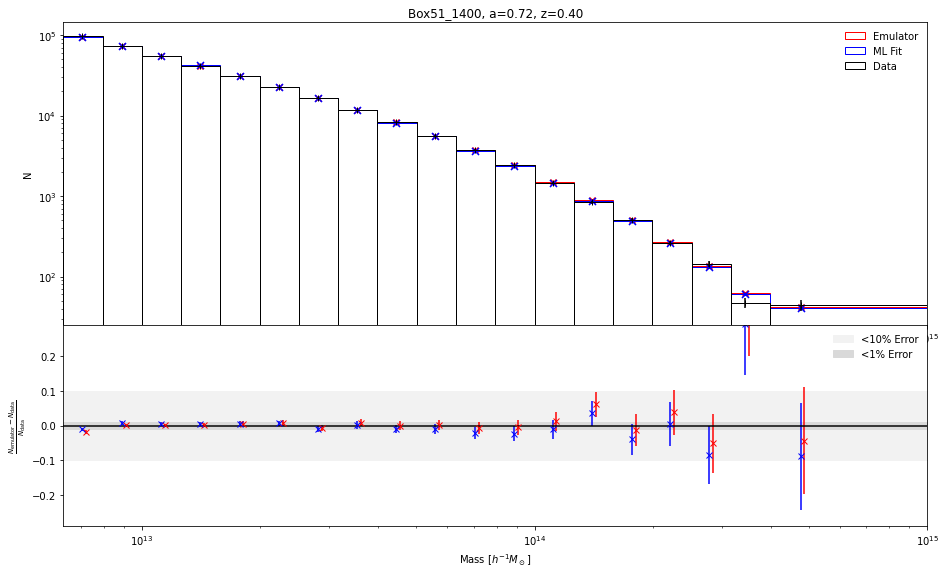

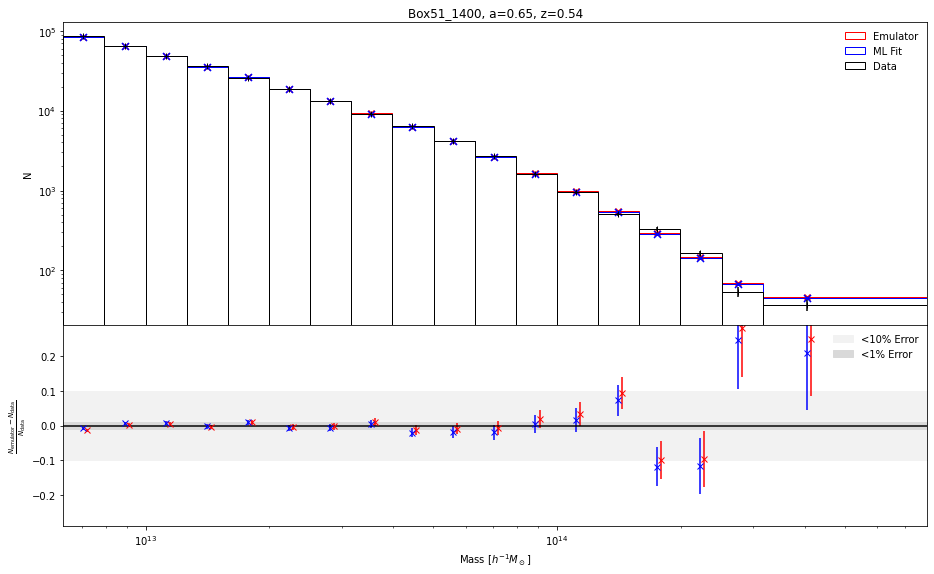

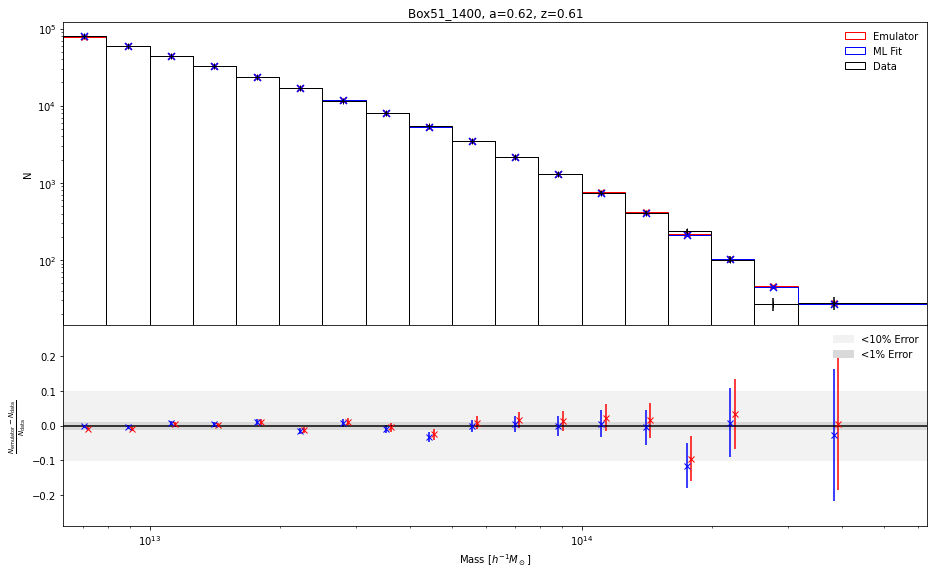

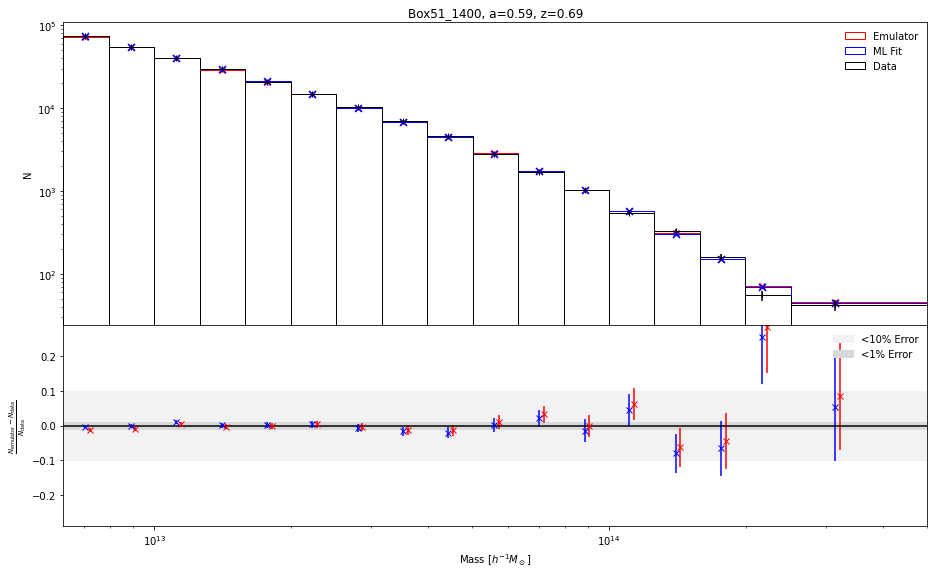

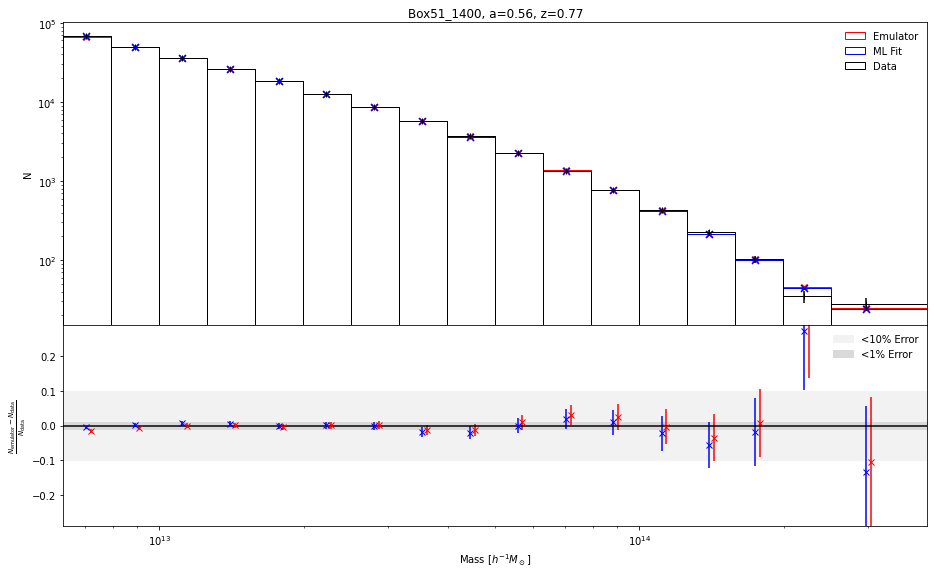

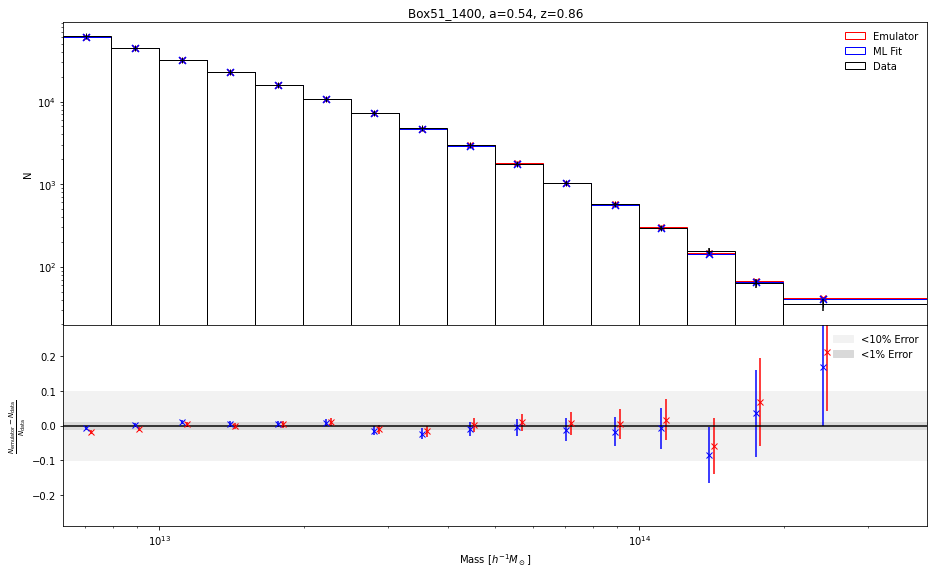

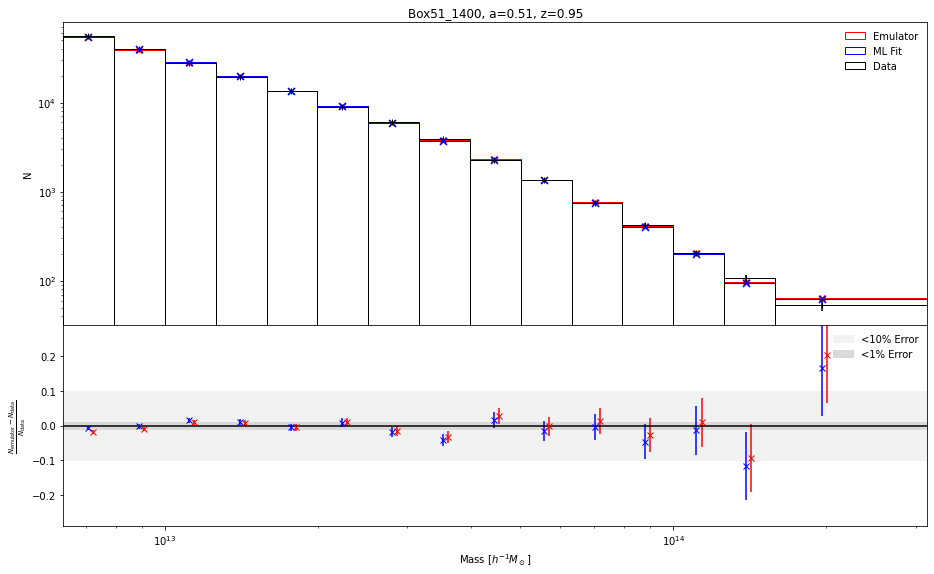

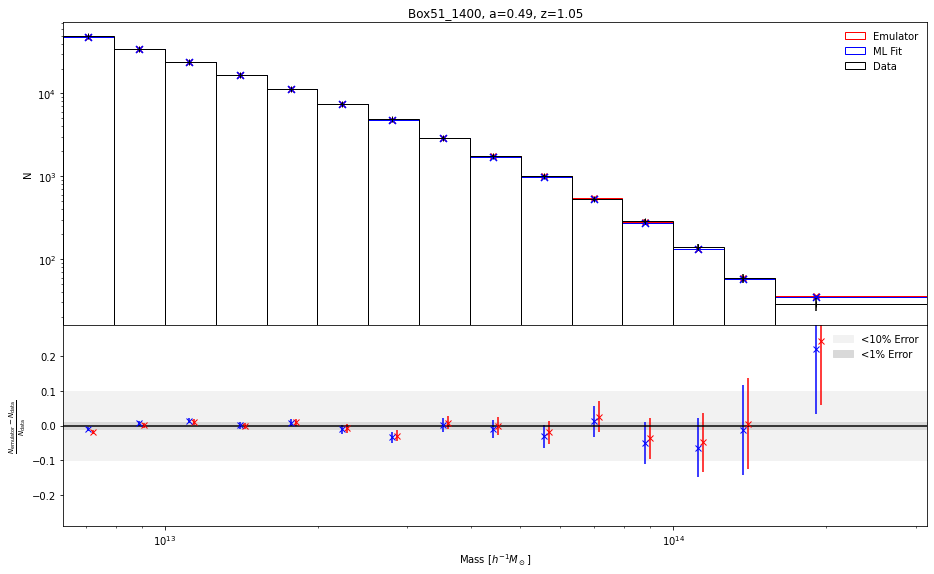

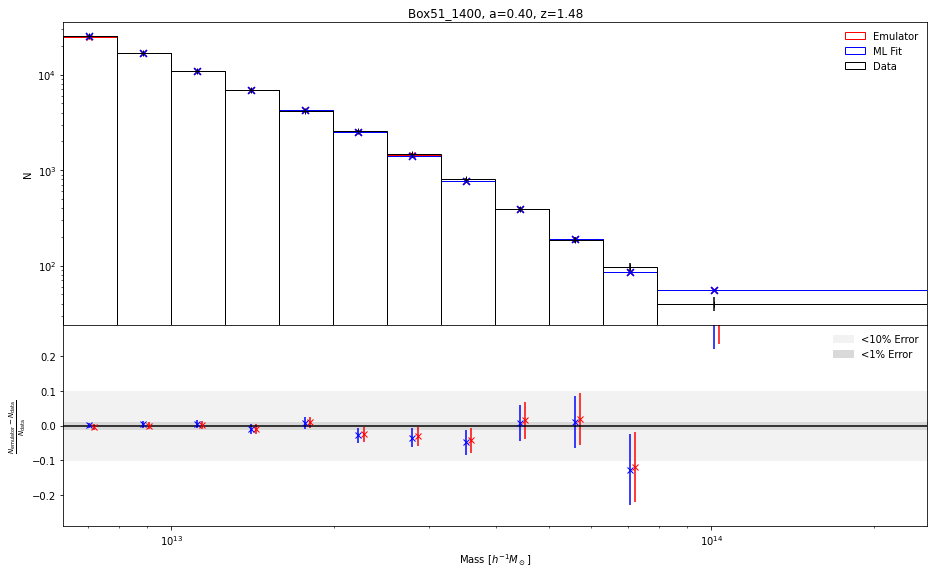

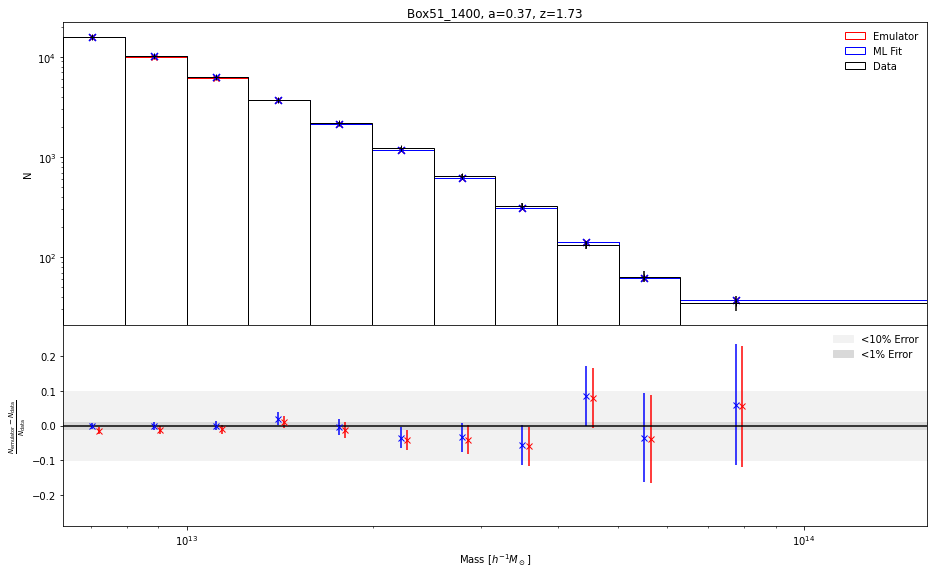

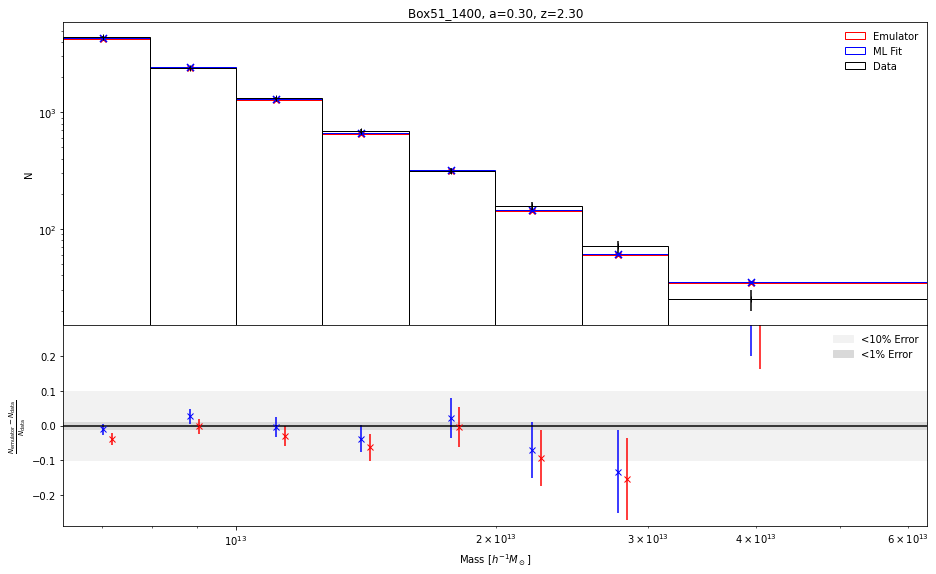

In [17]:
for a in tqdm(a_list):
    yerr = np.sqrt(np.diagonal(weighted_cov[a]))
    fig1 = plt.figure(figsize =(12, 7))

    axs=[fig1.add_axes((0.0,0.4,1,.6)), fig1.add_axes((0.0,0.0,1,.4))]
    plt.subplots_adjust(wspace=0, hspace=0)
    c_data = NvMs[a]

    Ms = M_data[a]
    N = N_data[a]
    edge_pairs = c_data['edge_pairs']

    edges = [edge[0] for edge in edge_pairs]
    edges += [edge_pairs[-1][1]]

    #shade in 1% and 10% error region
    edges = np.array(edges)
    
    

    y1 = 0.1*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.1*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    c_Ms = np.append(Ms, edges[-1])
    c_Ms = np.append(edges[0], c_Ms)
    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.95',label='<10% Error')

    y1 = 0.01*np.ones_like(N)
    y1 = np.append(y1, y1[-1])
    y1 = np.append(y1[0], y1)

    y2 = -0.01*np.ones_like(N)
    y2 = np.append(y2, y2[-1])
    y2 = np.append(y2[0], y2)

    axs[1].fill_between(c_Ms, y1, y2, alpha=1, color='0.85',label='<1% Error')


    dM = np.array([edges[1]-edges[0] for edges in edge_pairs])


    #Emulator 
    f_dNdM_MCMC =  lambda M:Emulator(ccl_cosmo, M/h, a)*vol/(h**3 * M * np.log(10)) # h / Msun
    tinker_eval_MCMC = np.array([quad(f_dNdM_MCMC, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])

    axs[0].scatter(Ms, tinker_eval_MCMC, marker='x', c='red')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges),
               align='edge', fill=False, ec='red', label='Emulator')
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_NvMemulator_loo_output.pkl"%(box, a), "wb") as f:
        pickle.dump({'Ms':Ms, 'tinker_eval':tinker_eval_MCMC, 'N':N, 'edges':edges}, f)

    tmp = np.array([c_tmp*10**(0.01)-c_tmp for c_tmp in Ms])
    axs[1].errorbar(Ms + tmp, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='red')

    #ML Fit

    mass_function = MassFuncAemulusNu_fitting()
    
    with open("/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/%s_%.2f_params.pkl"%(box, a), "rb") as f:
        MLE_params = pickle.load(f)
        print(list(MLE_params.values()))
        mass_function.set_params(list(MLE_params.values()))


    f_dNdM_MCMC =  lambda M:mass_function(ccl_cosmo, M/h, a)*vol/(h**3 * M * np.log(10)) # h / Msun
    tinker_eval_MCMC = np.array([quad(f_dNdM_MCMC, edge[0],  edge[1], epsabs=0, epsrel=1e-5)[0] for edge in edge_pairs])
    axs[0].scatter(Ms, tinker_eval_MCMC, s=50 , marker='x', c='blue')
    axs[0].bar(x=edges[:-1], height=tinker_eval_MCMC, width=np.diff(edges), 
               align='edge', fill=False, ec='blue', label='ML Fit')
    axs[1].errorbar(Ms, (tinker_eval_MCMC-N)/N, yerr/N, fmt='x', color='blue')



    #Data
    axs[0].bar(x=edges[:-1], height=N, width=np.diff(edges),
           align='edge', fill=False, ec='black', label='Data')
    axs[0].errorbar(Ms, N, yerr, fmt='+', c='black')

    axs[0].set_xscale('log')
    axs[0].set_yscale('log')
    axs[0].legend(frameon=False)
    axs[0].set_ylabel('N')

    axs[1].set_xscale('log')
    # axs[1].set_yscale('lin', linthresh=1e-2)    
    axs[1].legend(frameon=False)
    axs[1].axhline(0, c='black')
    axs[1].set_ylabel('N')
    axs[1].set_xlabel(r'Mass $[h^{-1}M_\odot]$')
    axs[1].set_ylabel(r'$\frac{N_{\rm emulator}-N_{\rm data}}{N_{\rm data}} $')
    axs[0].set_title('%s, a=%.2f, z=%.2f'%(box, a, scaleToRedshift(a)))

    left = np.ceil(np.log10(200*Mpart) * 10) / 10
    axs[0].set_xlim((10**left, np.max(edges)))
    axs[1].set_xlim((10**left, np.max(edges)))
    axs[1].set_ylim((-.29, .29))
    axs[1].set_yticks([-.2, -.1, 0, .1, .2])

    plt.savefig('/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/figures/emulator/%s_emufit_%.2f.pdf'%(box, a), bbox_inches='tight')

In [18]:
logM, sigM = Emulator._get_logM_sigM(cosmo, M_numerics, 0.3)

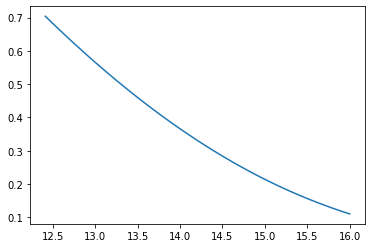

In [19]:
plt.plot(logM, sigM)

In [20]:
np.isclose(np.power(10,logM), M_numerics)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [21]:
1.686**2/2

1.421298